In [3]:
# en = args.encoder_layers
# de= args.decoder_layers
# random.seed(3000)
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
import nibabel as nib
import tqdm
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from utils import *
import pathlib
import surfa as sf


mgh = pathlib.Path('fetus_label_map')
mgh_files = list(mgh.glob('*.nii.gz'))
label_maps = [np.uint8(sf.load_volume(str(file_path)).data) for file_path in mgh_files]


labels = np.unique(label_maps)
in_shape = label_maps[0].shape



num_labels=8
# labels_in = range(max(labels) + num_labels + 1)
labels_in = np.unique(label_maps) # change this for feta

feta = pathlib.Path('/autofs/space/bal_004/users/jd1677/synthstrip/feta_3d')
feta_files = list(feta.glob('sub-???/anat/sub-???_rec-mial_dseg.nii.gz'))
# feta = pathlib.Path('feta_scaled')
# feta_files = list(feta.glob('*.nii.gz'))
# feta = pathlib.Path('feta_resized_192')
# feta_files = list(feta.glob('*.nii.gz'))
# feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]
feta_label_maps = [np.uint8(sf.load_volume(str(f)).resize([1,1,1],method='nearest').reshape([256,256,256]).data) for f in feta_files]


# feta_label_maps = [np.uint8(sf.load_volume(str(f)).resize([1,1,1],method='nearest').reshape([192,192,192]).data) for f in feta_files]
labels = np.unique(feta_label_maps)
# feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]
print(len(feta_label_maps))
print(feta_label_maps[0].shape)


40
(256, 256, 256)


# Build New Dataset

(110.52988979549582, 116.14070602407371, 115.92760476956812) [56, 64, 56]
(256, 256, 256)
(256, 256, 256)
(117.62357737387464, 119.01696160033573, 114.27516262152899) [52, 63, 55]
(256, 256, 256)
(114.5292405203228, 123.64630788749152, 117.29193668107328) [53, 64, 52]
(256, 256, 256)
(256, 256, 256)
(110.18198457036446, 113.25068901303538, 105.47387071029529) [52, 63, 47]
(256, 256, 256)
(110.5447872962974, 116.11013578520348, 119.5587675186717) [54, 64, 61]
(256, 256, 256)
(256, 256, 256)
(117.43588298796703, 125.11535848758524, 117.72205166012796) [54, 63, 51]
(256, 256, 256)
(118.58633233938737, 124.10068311195445, 117.66321496340471) [53, 63, 53]
(256, 256, 256)
(256, 256, 256)
(117.70599902425235, 124.73006898627114, 119.96476365476771) [54, 63, 54]
(256, 256, 256)
(113.40014599455431, 119.29698248065348, 118.7065464674692) [56, 64, 54]
(256, 256, 256)
(116.13166185558306, 119.5881589293536, 118.9038275820215) [53, 64, 55]
(256, 256, 256)
(109.11351082661689, 114.94362246580067, 1

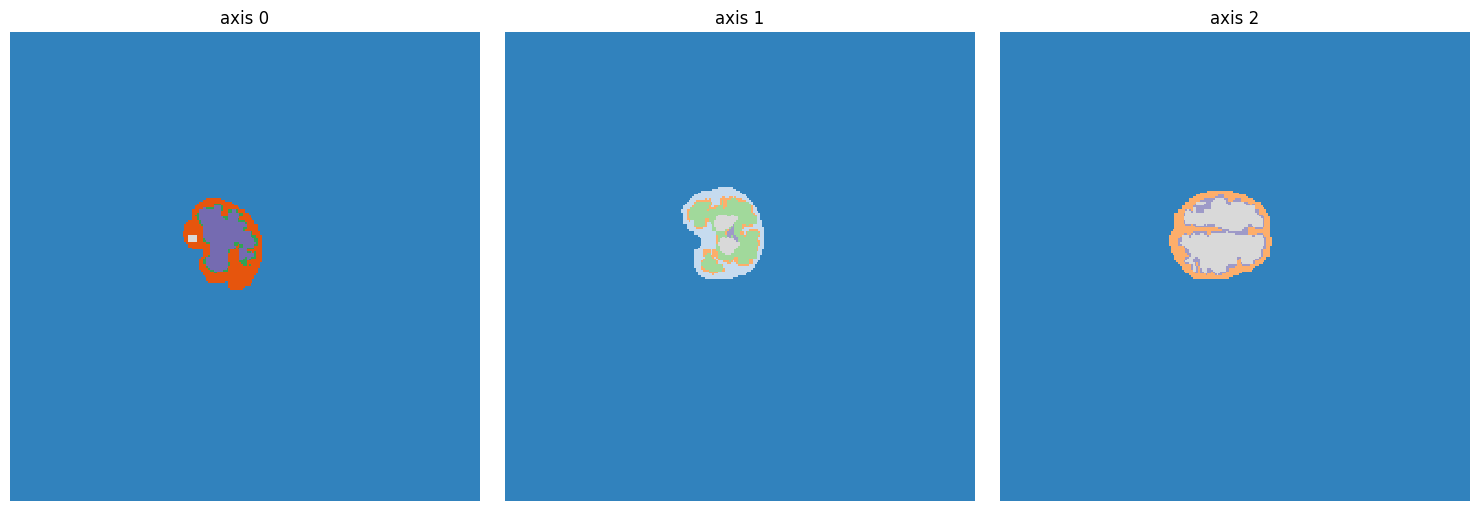

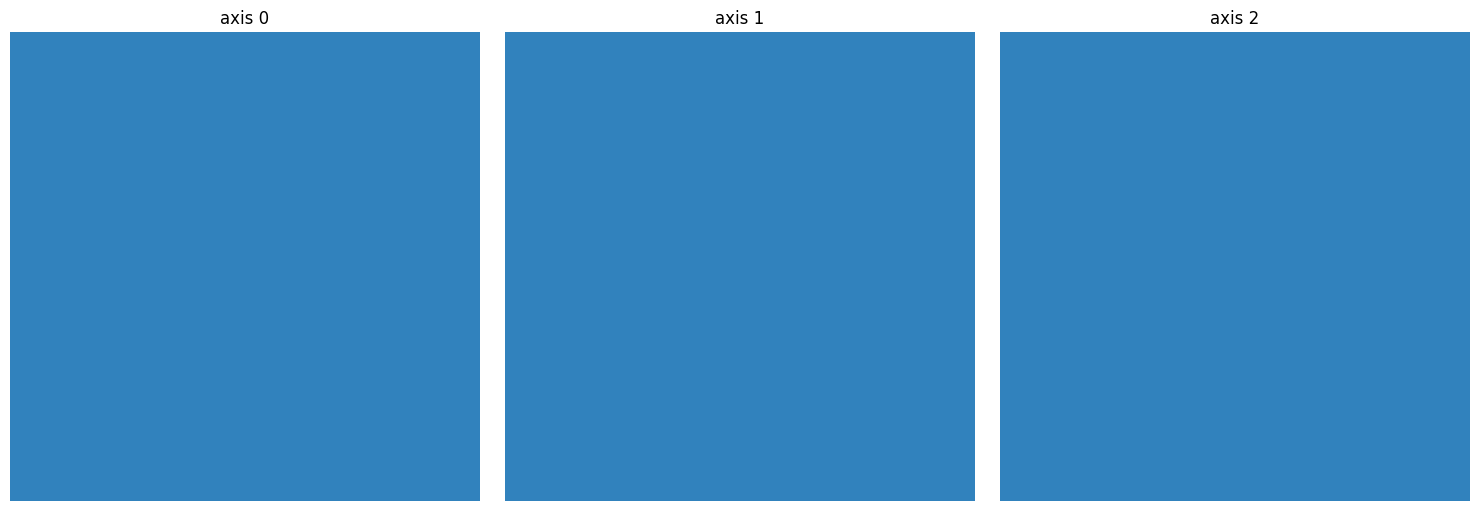

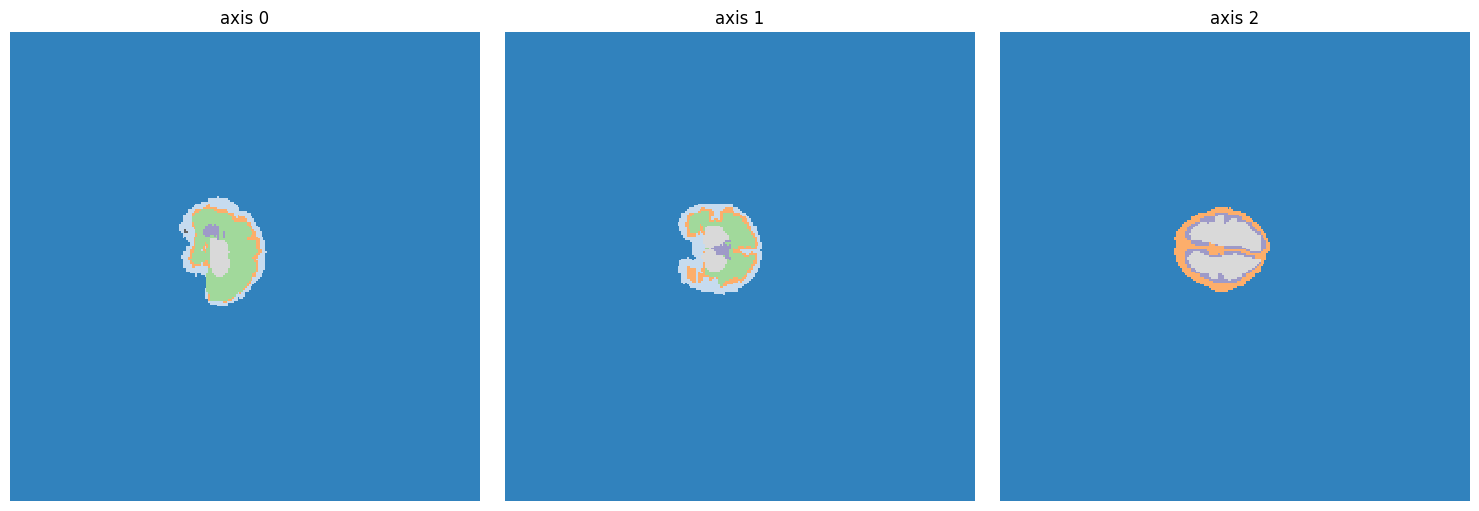

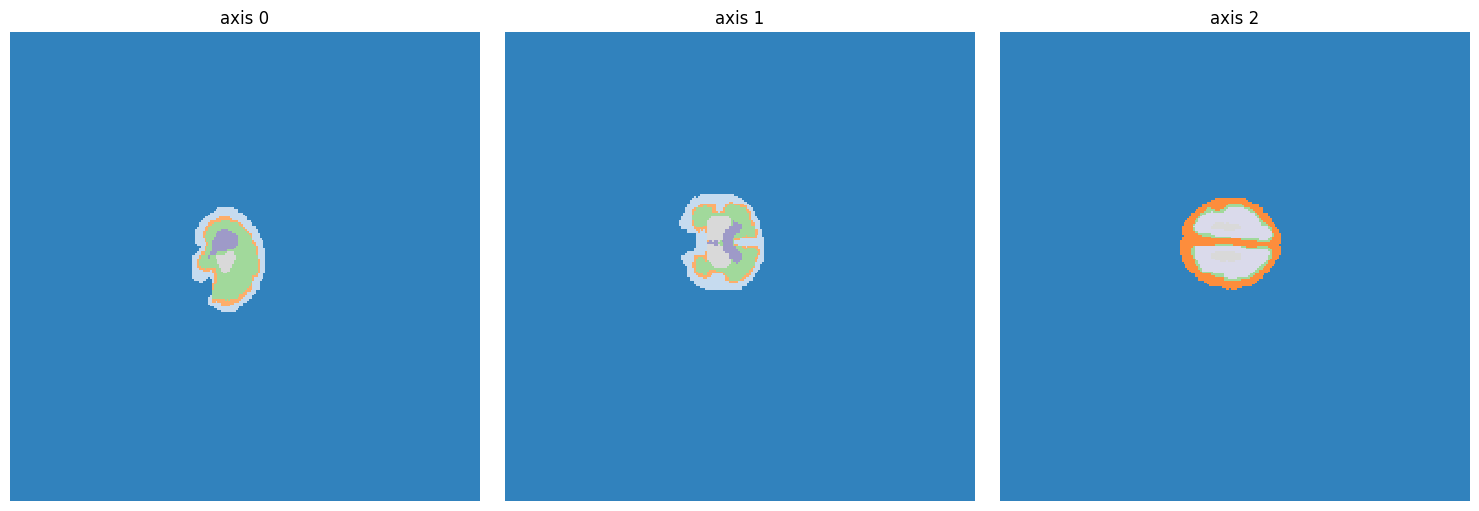

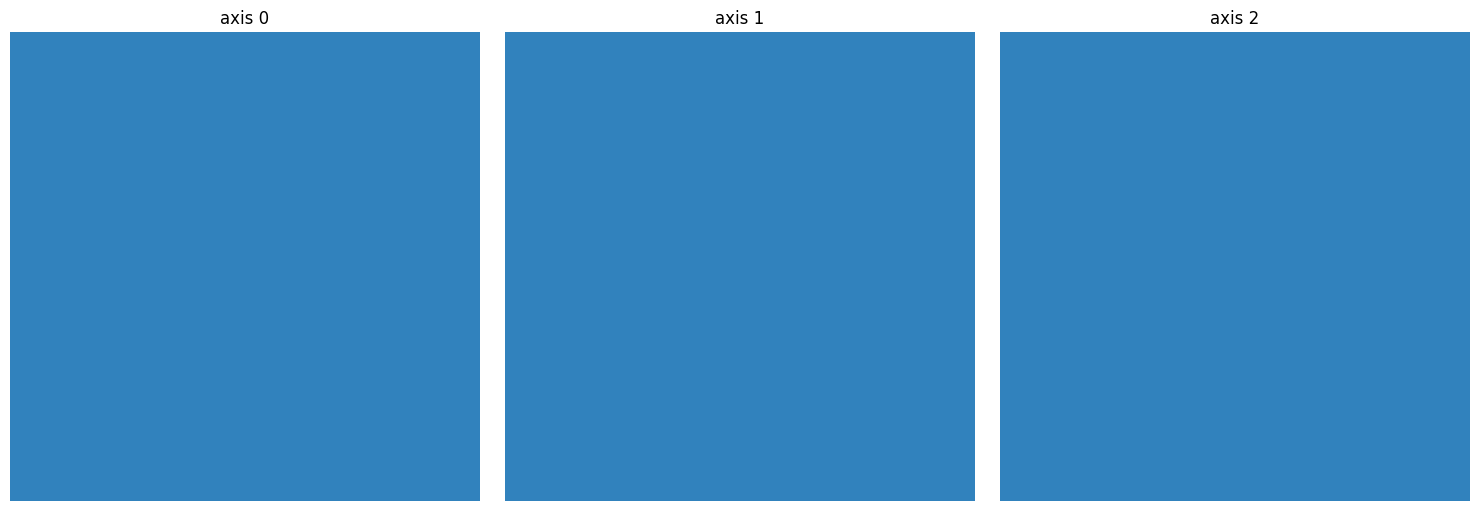

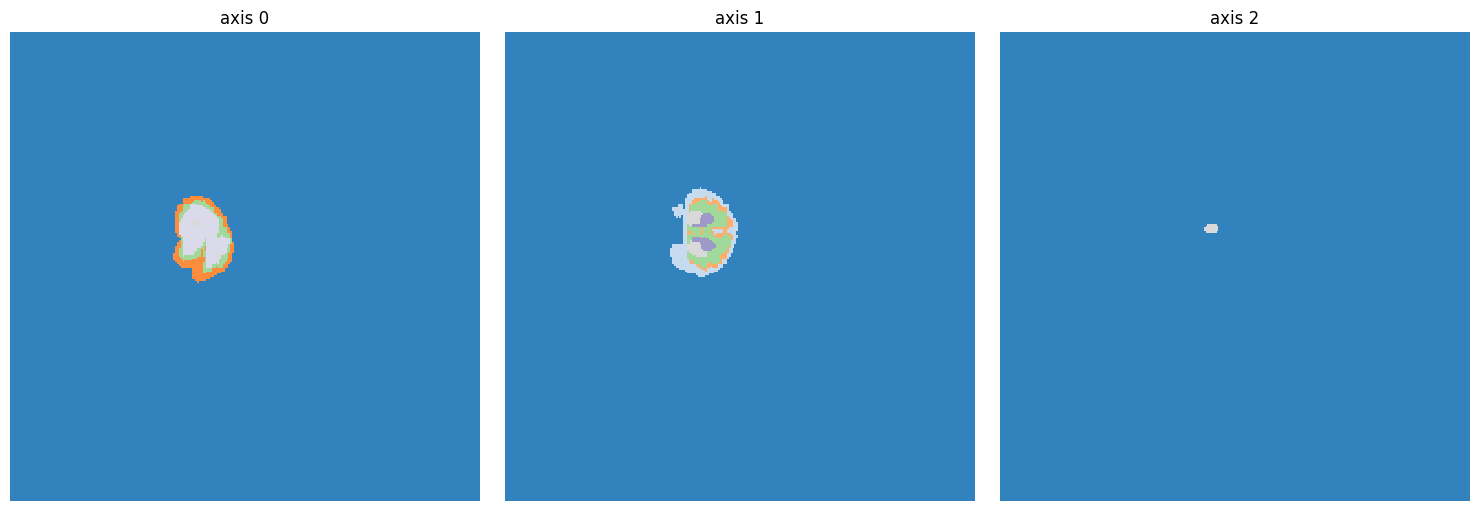

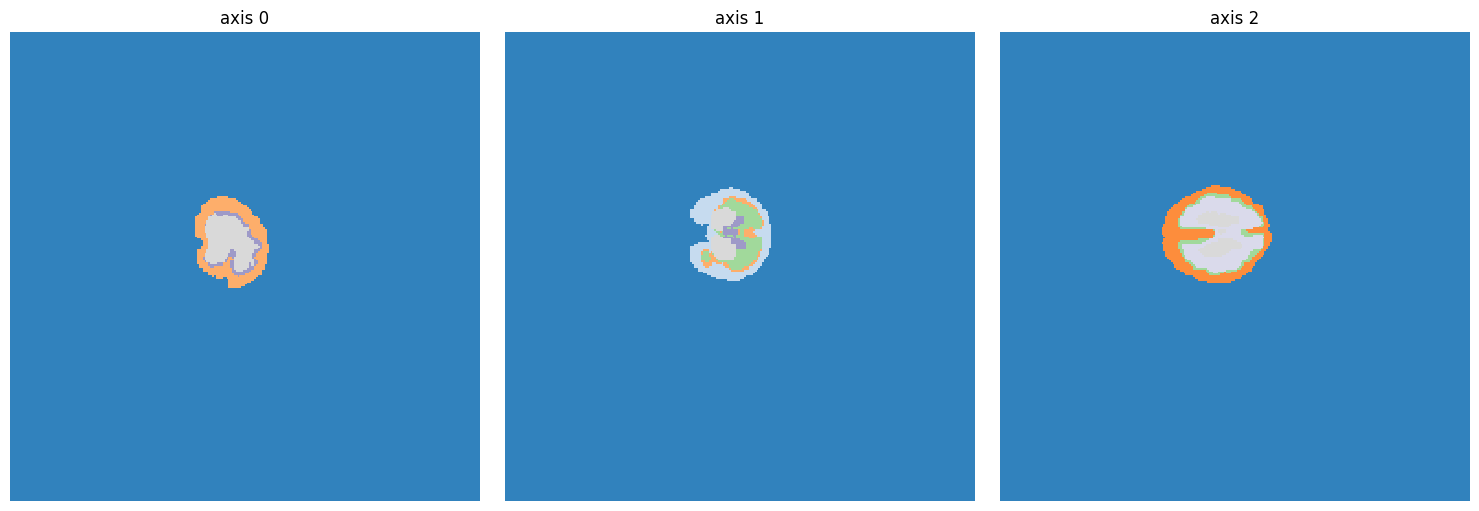

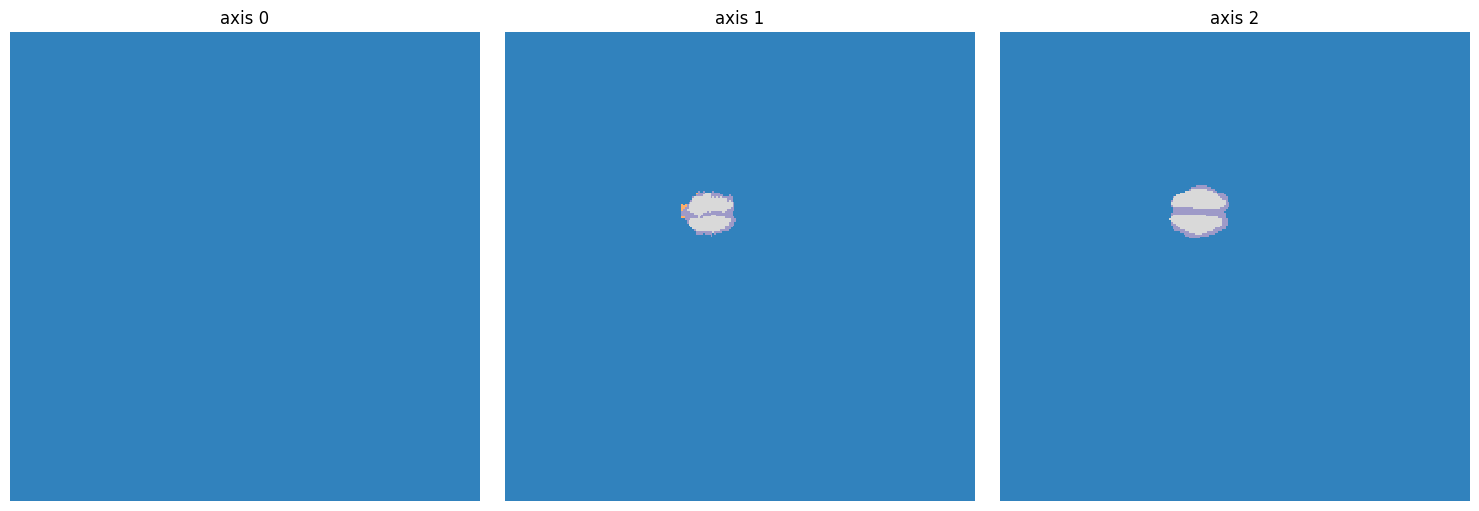

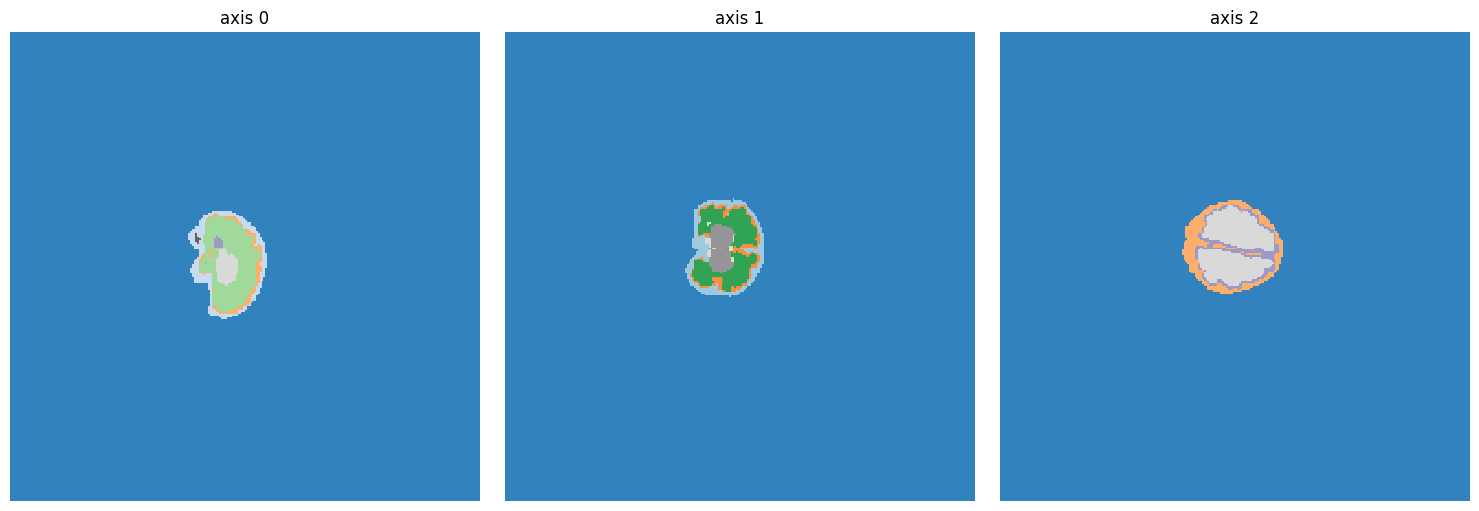

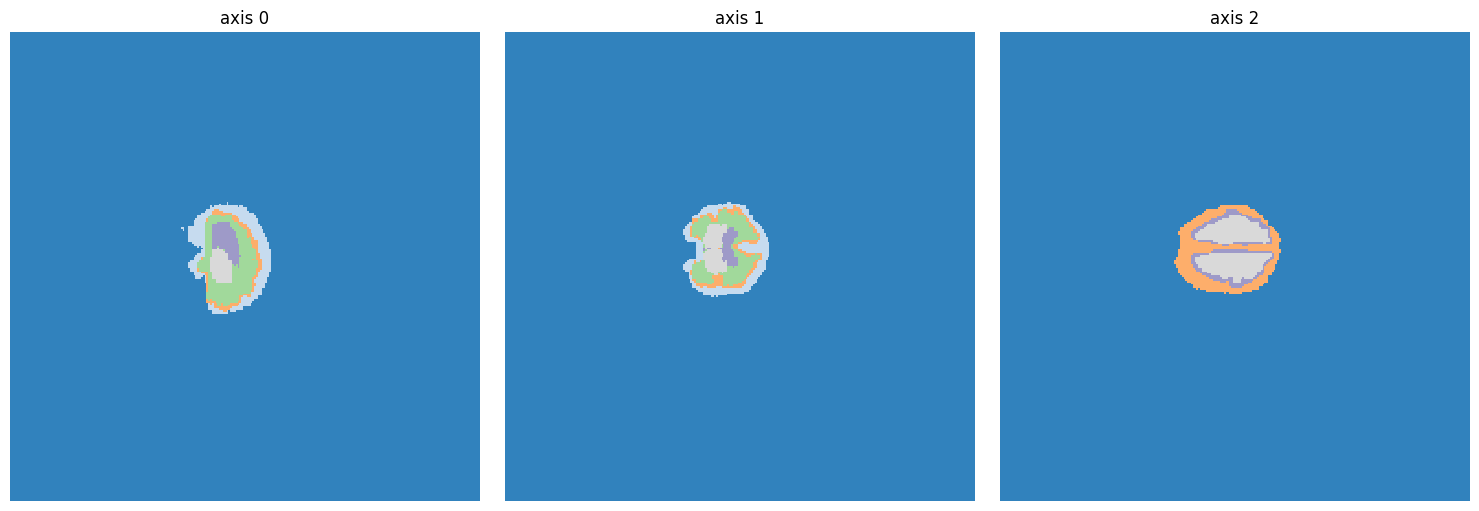

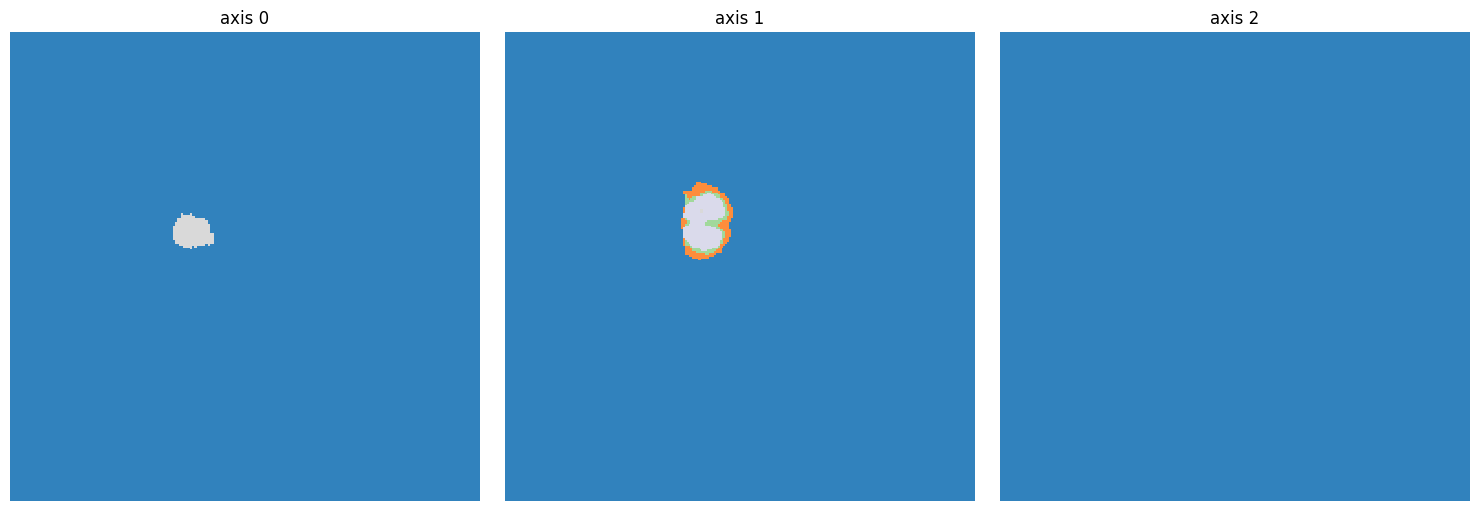

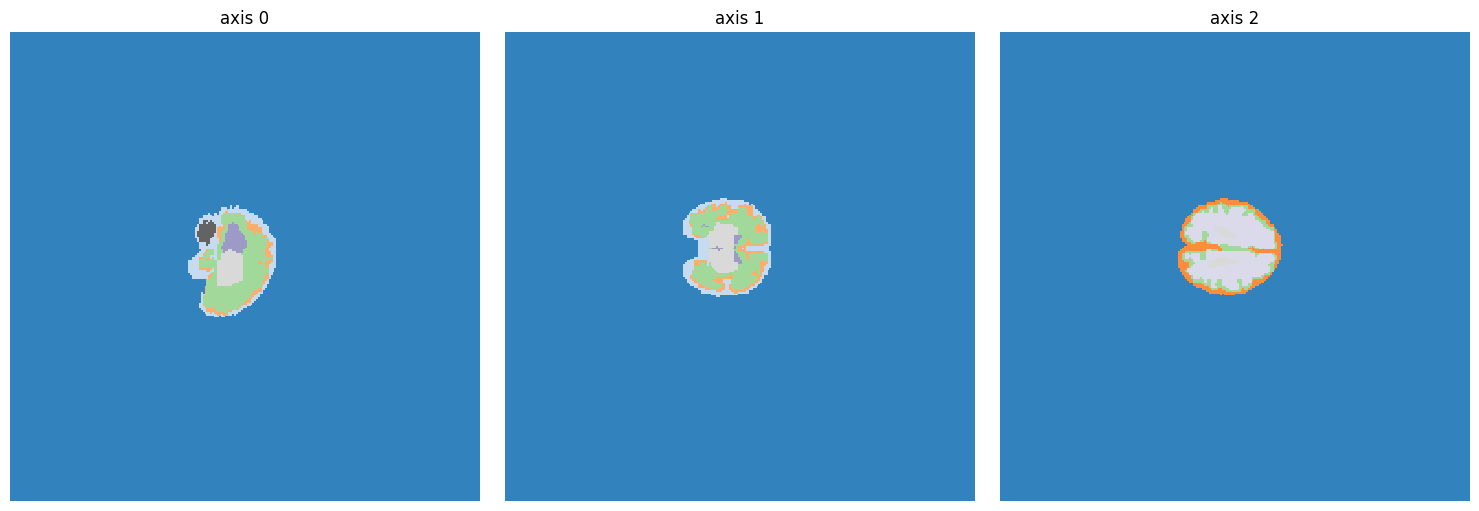

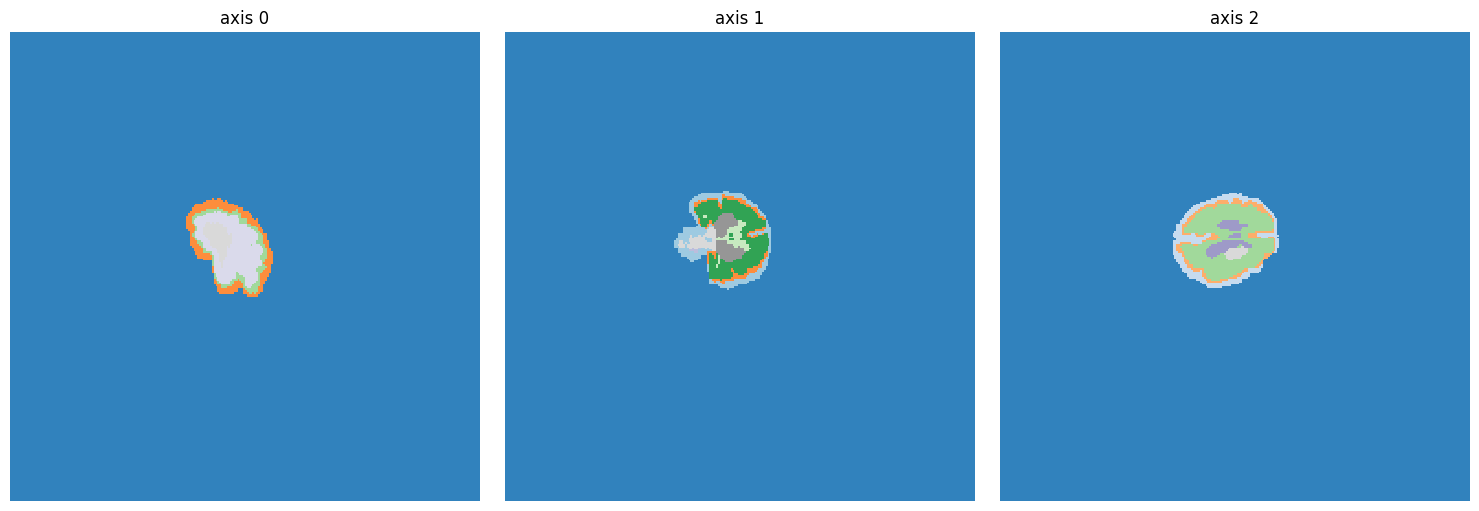

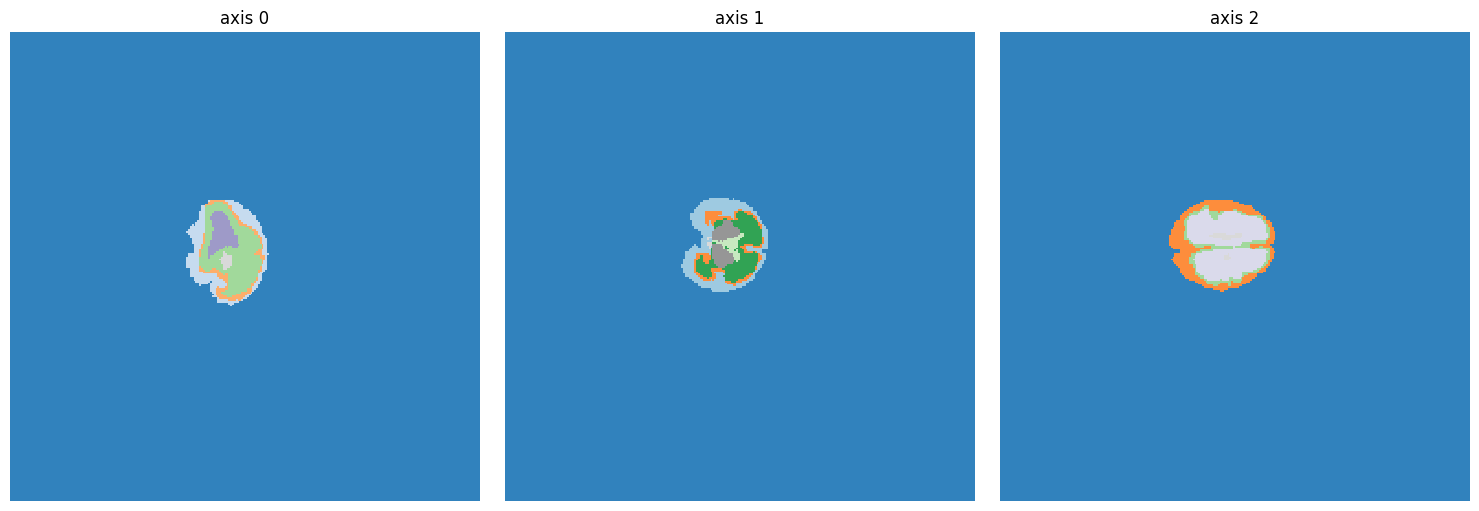

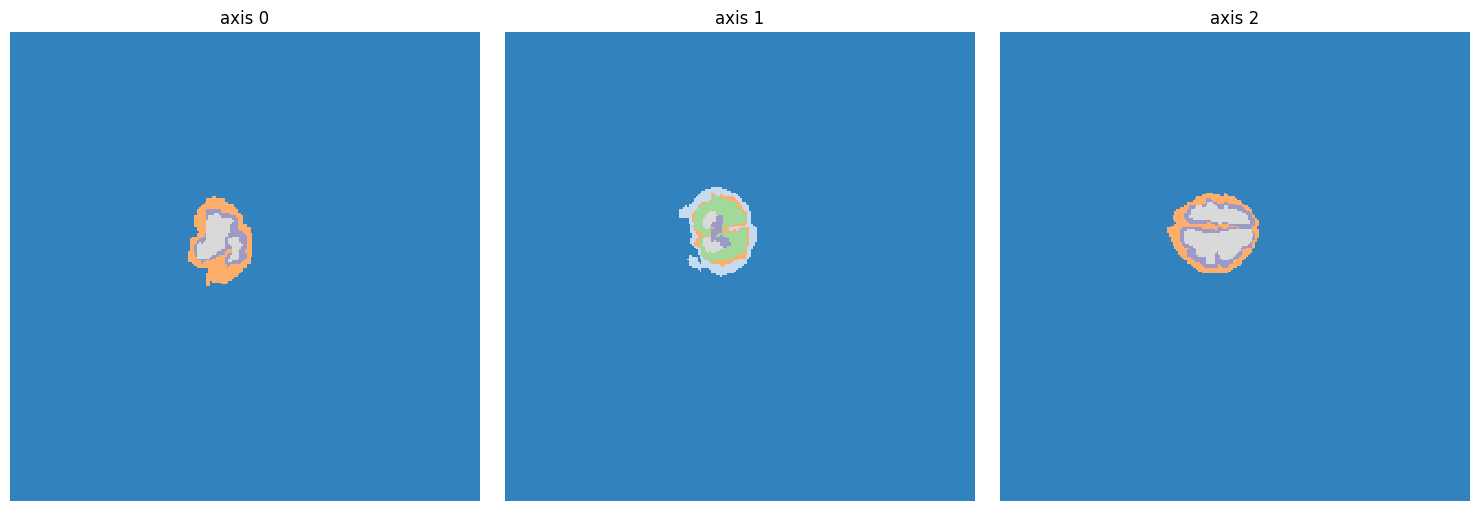

In [4]:

# from scipy.ndimage import zoom
from scipy.ndimage import find_objects, zoom, center_of_mass
def scale_down_brain(label_map, scale_factor=10):
    scaled_label_map = zoom(label_map, 1/scale_factor, order=0, mode='constant', cval=0)
    pad_amount = np.floor((np.array(label_map.shape) - np.array(scaled_label_map.shape)) / 2).astype(int)
    padded_label_map = np.pad(scaled_label_map, (
        (pad_amount[0], label_map.shape[0] - scaled_label_map.shape[0] - pad_amount[0]),
        (pad_amount[1], label_map.shape[1] - scaled_label_map.shape[1] - pad_amount[1]),
        (pad_amount[2], label_map.shape[2] - scaled_label_map.shape[2] - pad_amount[2])
    ), mode='constant', constant_values=0)

    return padded_label_map


def resize_brain_to_width(label_map, desired_width, interpolation_order=1):
    non_zero_indices = np.nonzero(label_map)
    # Compute the maximum extent along each axis
    max_extent = [np.max(indices) - np.min(indices) + 1 if len(indices) > 0 else 0 for indices in non_zero_indices]

    # Calculate the dynamic scale factor based on the maximum extent and desired width
    zoom_factor = min(1, desired_width / max(max_extent))
    scale_factor = 1 / zoom_factor
    # print(scale_factor)

    # print(scale_factor)
    # Check if any dimension is larger than the desired width
    if any(extent > desired_width for extent in max_extent):
        # Scale down the brain if needed
        # scaled_label_map = zoom(label_map, scale_factor, order=0, mode='nearest', cval=0)
        # scaled_label_map = sf.Volume(label_map).resize([scale_factor,scale_factor,scale_factor],method='nearest').reshape([192,192,192]).data
        scaled_label_map = zoom(label_map, zoom_factor, order=0, mode='nearest', cval=0)

    
        pad_amount = np.floor((np.array(label_map.shape) - np.array(scaled_label_map.shape)) / 2).astype(int)
        padded_label_map = np.pad(scaled_label_map, (
            (pad_amount[0], label_map.shape[0] - scaled_label_map.shape[0] - pad_amount[0]),
            (pad_amount[1], label_map.shape[1] - scaled_label_map.shape[1] - pad_amount[1]),
            (pad_amount[2], label_map.shape[2] - scaled_label_map.shape[2] - pad_amount[2])
        ), mode='constant', constant_values=0)
        # padded_label_map = scaled_label_map
        com = center_of_mass(padded_label_map)
        max_extent_scaled = [np.max(indices) - np.min(indices) + 1 if len(indices) > 0 else 0 for indices in np.nonzero(padded_label_map)]
        print(com,max_extent_scaled)
        
        return padded_label_map
    else:
        # Return the original label_map if no scaling is needed
        return label_map
    
def shift_brain_to_center(label_map, center_coordinates):
    original_center = np.array(label_map.shape) // 2
    shift_amount = np.array(center_coordinates) - original_center

    shifted_label_map = np.roll(label_map, shift_amount, axis=(0, 1, 2))
    shifted_label_map[shift_amount[0]:, shift_amount[1]:, shift_amount[2]:] = 0  # Set background for the shifted region

    return shifted_label_map
    
def shift_brain_right(label_map, shift_amount=50):
    shifted_label_map = np.roll(label_map, shift_amount, axis=2)
    shifted_label_map[:, :, :shift_amount] = 0  # Set background for the shifted slices
    return shifted_label_map
    
ref=label_maps[0]  
new_label_maps = []
for i in range(len(feta_label_maps)):
    fet = feta_label_maps[i]
    # print(fet.shape)
    # fet = scale_down_brain(fet, scale_factor=3)
    desired_width = 64  # Set your desired width here
    fet = resize_brain_to_width(fet, desired_width)

    # fet=shift_brain_right(fet)
    # x,y,z = find_center_of_mass(ref)
    # print(x,y,z)
    # fet = shift_brain_to_center(fet,[x,y,z])
    # print(find_center_of_mass(fet))
    new_label_maps.append(fet)
    print(fet.shape)
    nib.save(nib.Nifti1Image(fet.astype(np.int32), np.eye(4), header=None), f"feta_resized_256/sub_{i}.nii.gz")

# feta_label_maps=new_label_maps
for i in range(15):
    ne.plot.volume3D(new_label_maps[i], cmaps=['tab20c'])

In [5]:


from scipy.ndimage import binary_dilation, gaussian_filter
from scipy.ndimage import binary_dilation, binary_erosion, gaussian_filter
from skimage.morphology import ball

from scipy.ndimage import binary_dilation, binary_erosion
from skimage.morphology import ball

import numpy as np


from scipy.ndimage import center_of_mass

from scipy.ndimage import center_of_mass


import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage.measurements import center_of_mass

import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage.measurements import center_of_mass

import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage.measurements import center_of_mass



# def generate_random_label_maps_feta(brain_maps1, fov_maps):
#     return [
#         np.roll(
#             brain_maps1[selected_brain_index] + fov * (brain_maps1[selected_brain_index] == 0),
#             np.round(np.random.uniform(0.2, 0.8, size=2) * np.array(brain_maps1[selected_brain_index].shape[:2])) * np.random.choice([-1, 1], size=2),
#             axis=(0, 1)
#         )
#         for selected_brain_index, fov in zip(np.random.choice(len(brain_maps1), len(fov_maps)), fov_maps)
#     ]



    
    
from skimage import transform
import numpy as np

from scipy.ndimage import binary_dilation
from skimage.transform import rescale

# def scale_brain_maps(brain_maps, scale_factor):
#     target_shape = (256, 256, 256)
#     return [
#         np.pad(
#             rescale(b.astype(float), scale_factor, anti_aliasing=True, preserve_range=True).astype(int),
#             [(0, max(0, target_shape[i] - rescale(b.astype(float), scale_factor, anti_aliasing=True, preserve_range=True).shape[i])) for i in range(3)],
#             mode='constant'
#         )
#         for b in brain_maps
#     ]
    
# def get_fov(a, max_shift=60):
#     a_copy = np.copy(a)
#     best_directions = []
#     for i in range(len(a)):
#         b = a_copy[i]
#         m = (b >= 1) & (b < 8)
#         m = binary_dilation((m > 0), structure=np.ones((2, 2, 2)))

#         max_sum = 0
#         best_shift = 0
#         best_direction = 0

#         for d in range(3):
#             for shift in range(-max_shift, max_shift + 1):
#                 shifted_m = np.roll(m, shift, axis=d)
#                 current_sum = np.sum(b[shifted_m])

#                 if current_sum > max_sum:
#                     max_sum = current_sum
#                     best_shift = shift
#                     best_direction = d

#         shifted_m = np.roll(m, best_shift, axis=best_direction)
#         best_directions.append(best_direction)
#         b[m] = 0
#         b[m] = a_copy[i][shifted_m]
        
#         a_copy[i] = b

#     return a_copy , best_directions



# Show.
# print(len(label_maps),np.max(label_maps[0]))
# num_row = 2
# per_row = 8

# brain_maps = get_brain(label_maps)
# fov_maps = get_fov(label_maps)


{'in_shape': [192, 192, 192], 'labels_in': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 'labels_out': {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}, 'aff_shift': 64, 'one_hot': True, 'zero_background': 0.2, 'aff_scale': 0.5, 'aff_rotate': 180, 'bias_max': 0.2, 'blur_max': 1, 'crop_prob': 1, 'up_scale': True, 'slice_prob': 1, 'slice_stride_min': 3, 'slice_stride_max': 10, 'aff_shear': 0.05}


2024-02-23 16:55:14.640045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22996 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:41:00.0, compute capability: 7.5


(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)


2024-02-23 16:55:22.820678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


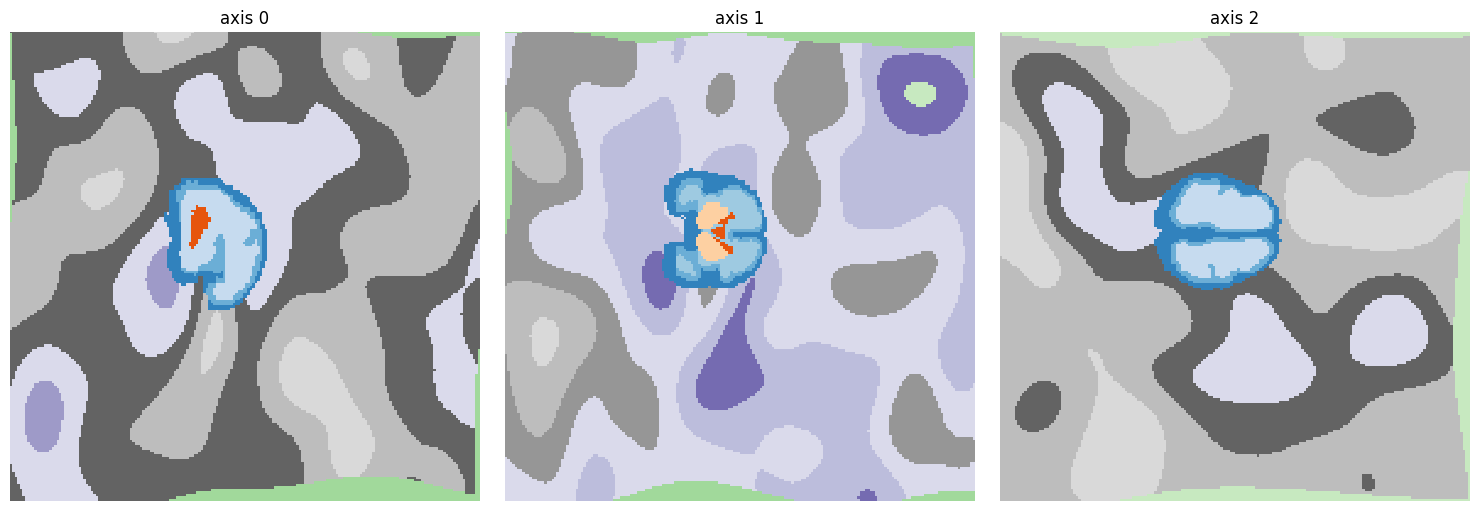

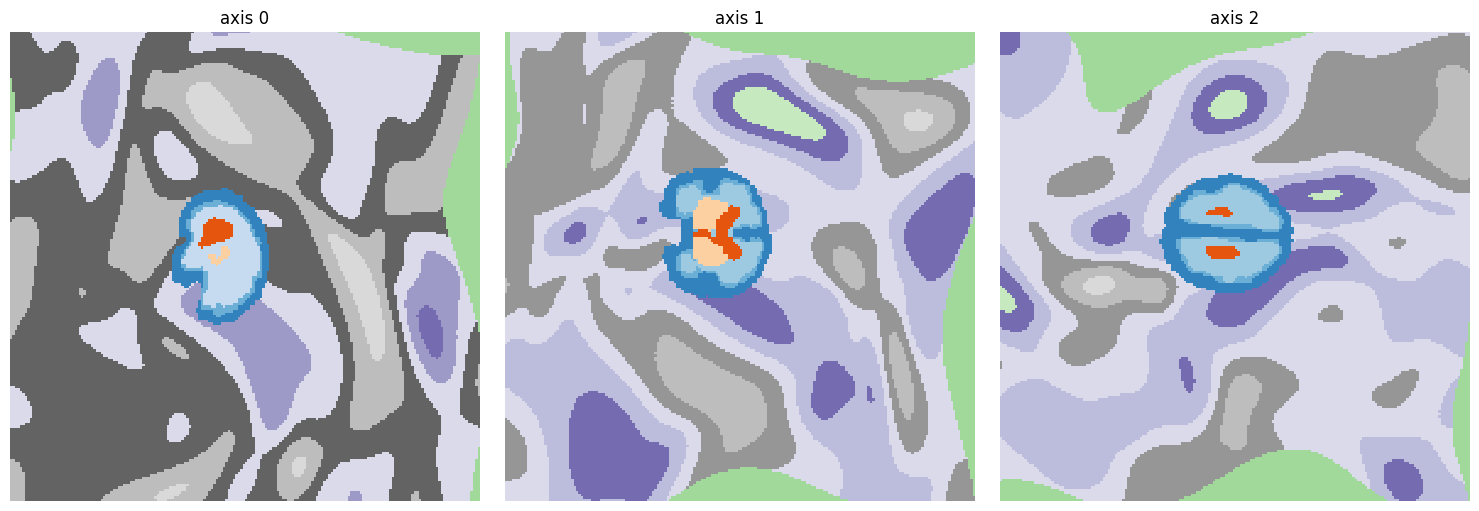

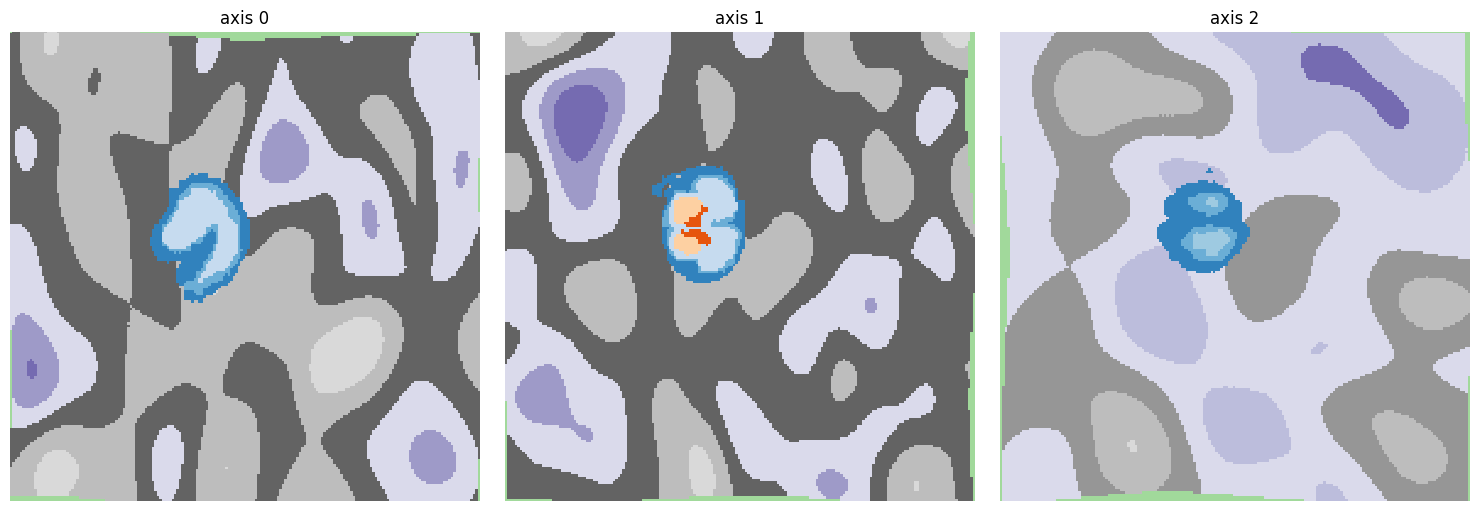

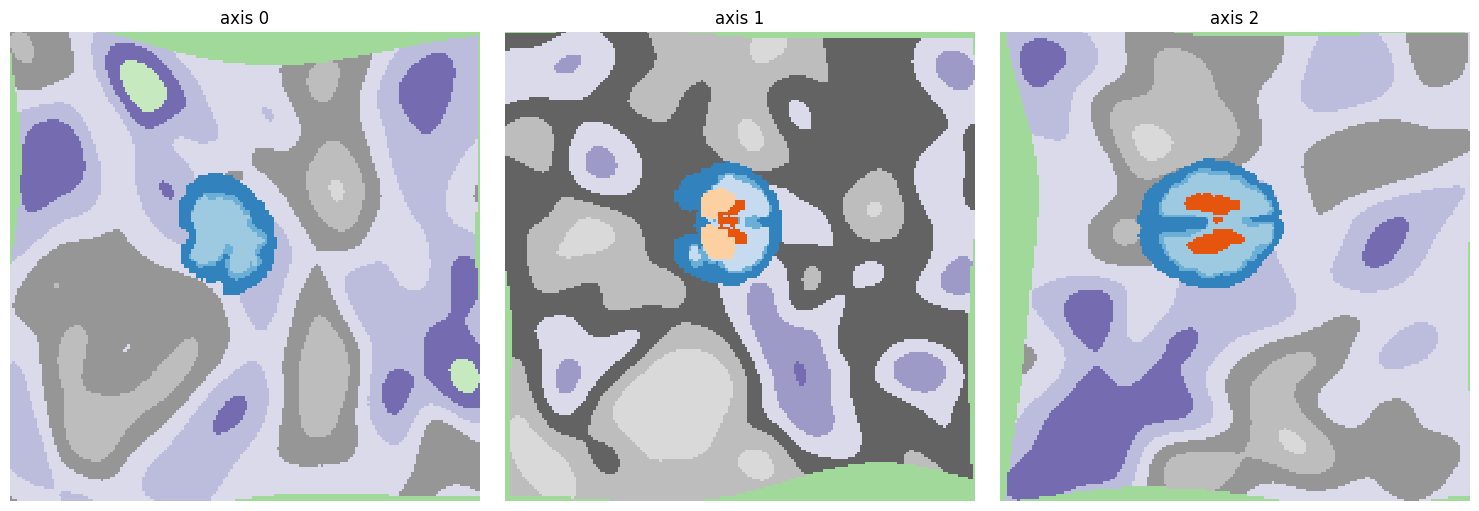

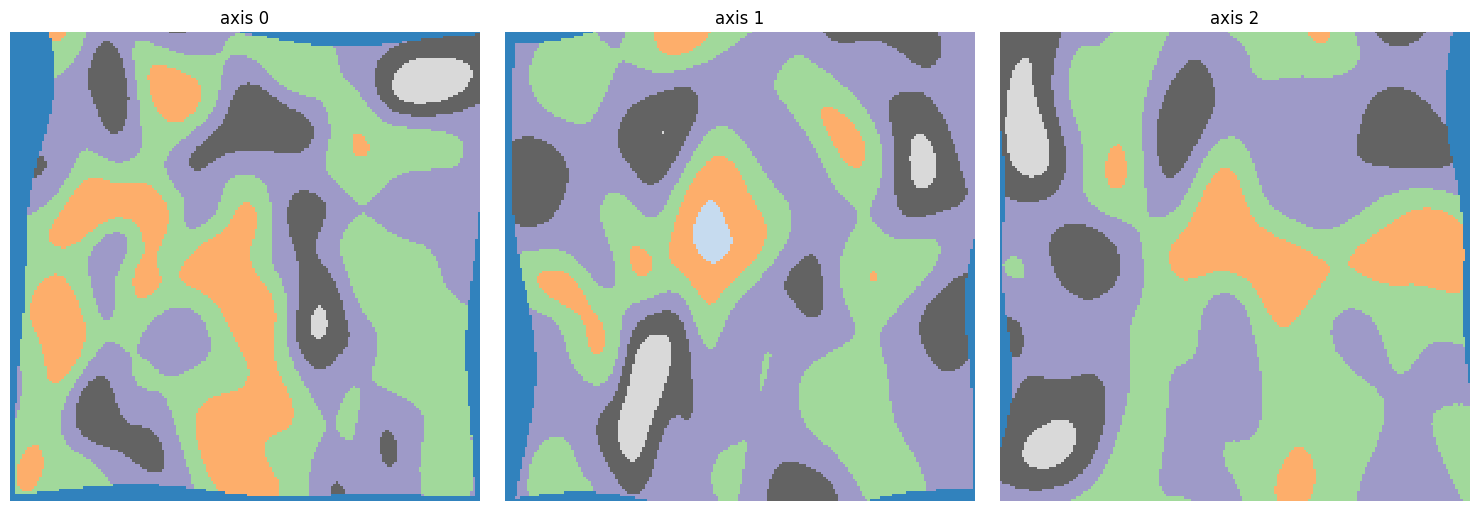

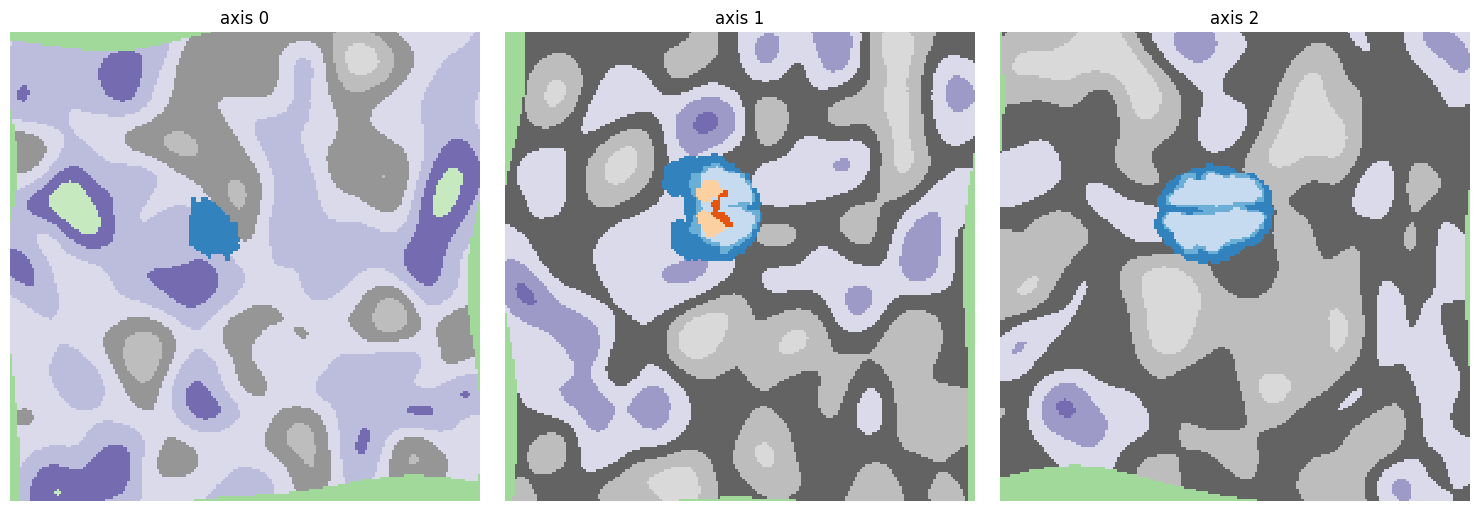

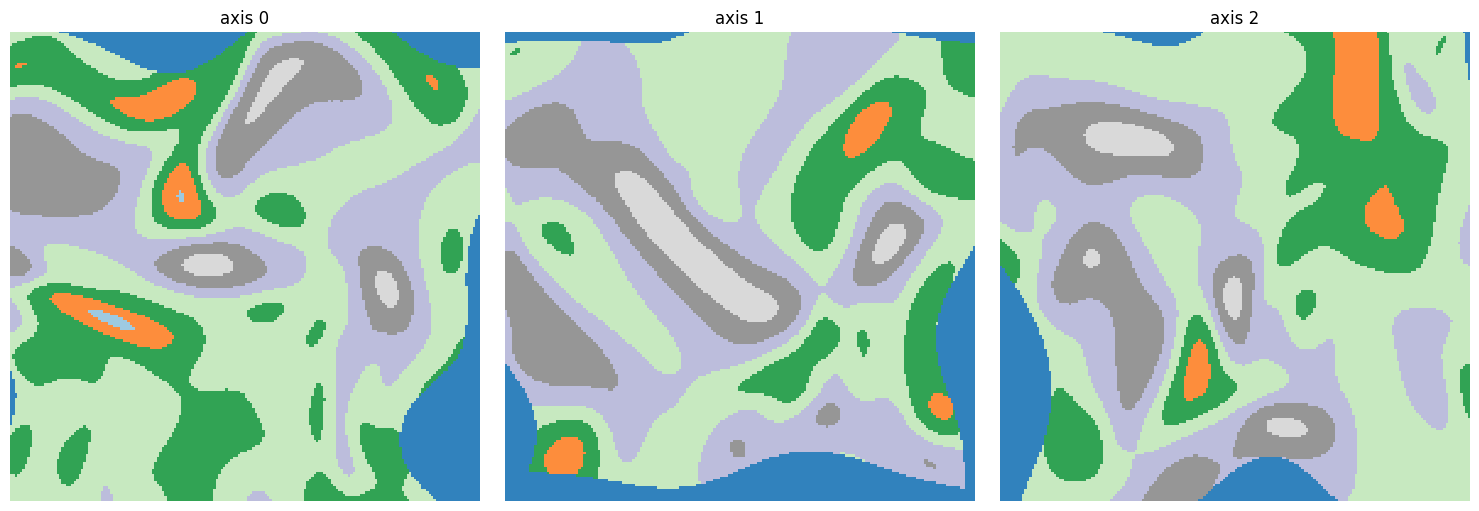

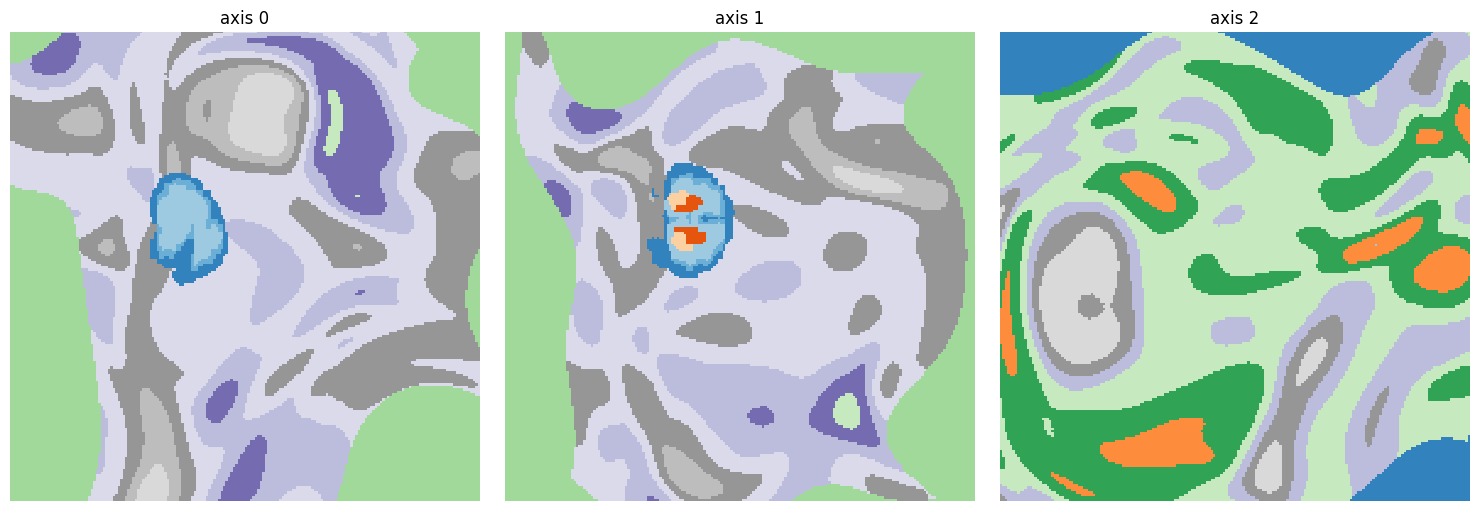

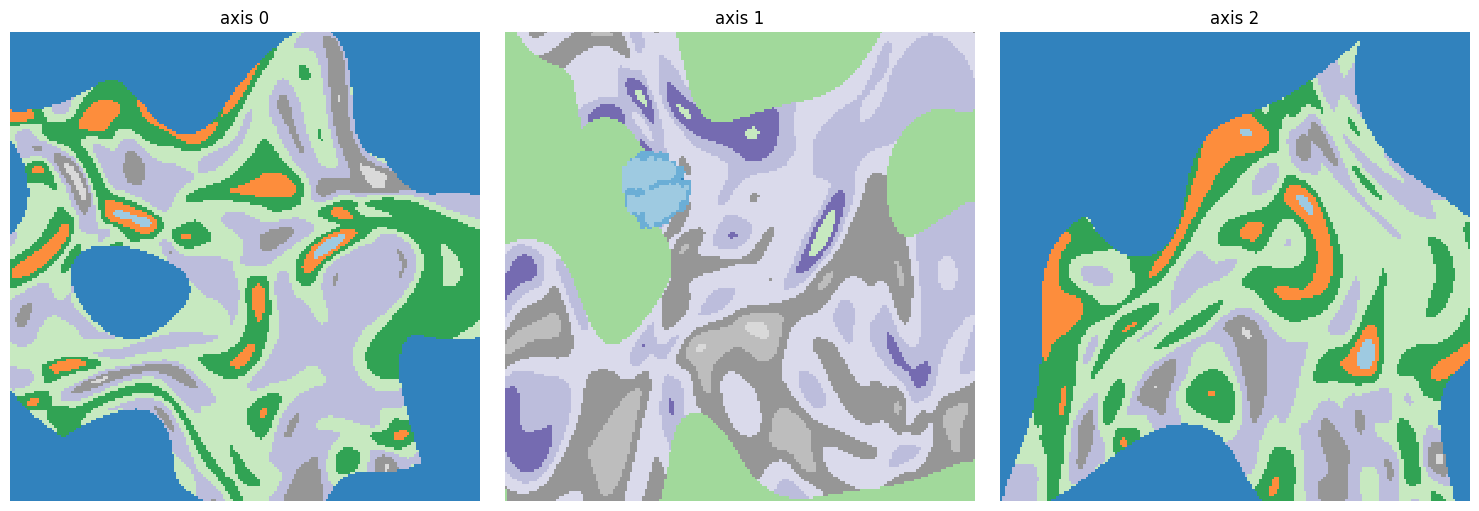

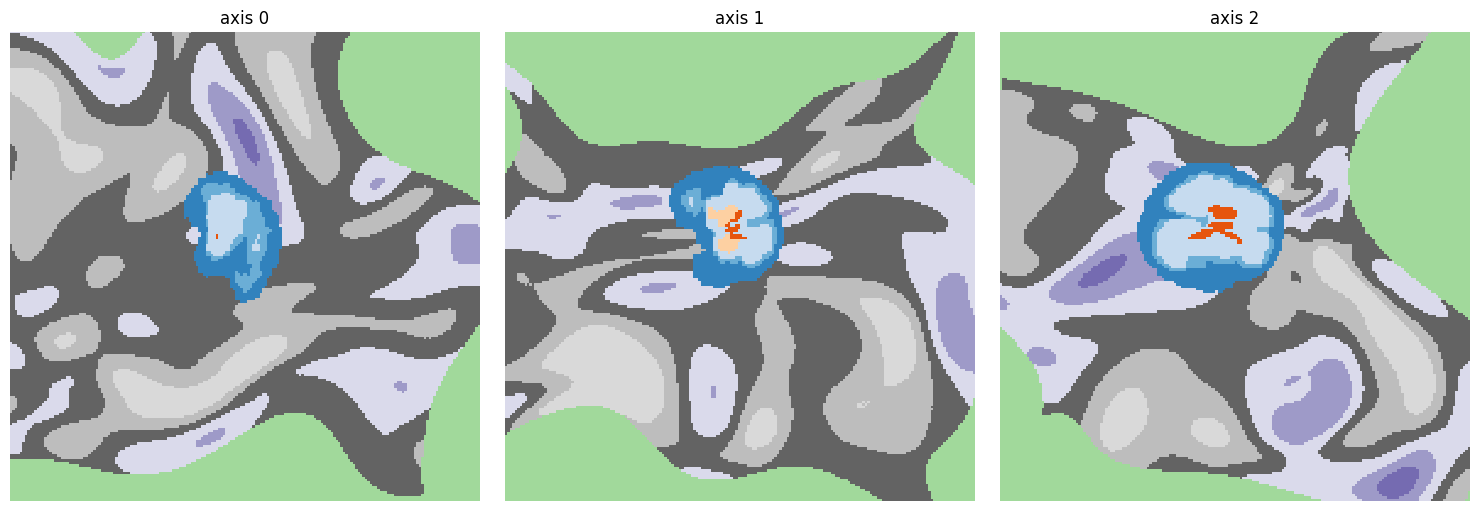

In [6]:
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation

def create_model(model_config):
    print(model_config)
    return ne.models.labels_to_image_new(**model_config)
    
import json

with open("params_192.json", "r") as json_file:
    config = json.load(json_file)

# Access the configuration

model3_config = config["labels_to_image_model_with_shapes"]

# Convert labels_out keys to integers for all models

model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}

# Now you have the modified configuration

model3 = create_model(model3_config)

# #brain
# model1 = ne.models.labels_to_image_new(
#     in_shape=in_shape,
#     labels_in=labels_in,
#     labels_out={i: i if i in (1, 2, 3, 4, 5, 6, 7) else 0 for i in labels_in},
#     warp_min=0.1,  # Adjust this value for a small warping change
#     warp_max=0.2,  # Adjust this value for a small warping change
#     one_hot=False,
#     aff_rotate=20,
#     aff_shift=0,
#     up_scale=False,
#     aff_scale=0.0

# )

# #body
# model2 = ne.models.labels_to_image_new(
#     in_shape=in_shape,
#     labels_in=labels_in,
#     labels_out={i: 0 if i in (1, 2, 3, 4, 5, 6, 7) else i for i in labels_in},
#     aff_rotate=5,
#     aff_shear=0.0,
#     aff_shift=1,
#     blur_max=1,
#     warp_min=0.1,  # Adjust this value for a small warping change
#     warp_max=1,  # Adjust this value for a small warping change
#     slice_prob=1,
#     one_hot=False,
#     crop_prob=1,
#     aff_scale=1

# )

# #both
# model3 = ne.models.labels_to_image_new(
#     in_shape=in_shape,
#     labels_in=labels_in,
#     labels_out={f: 1 if f in (1, 2, 3, 4, 5, 6, 7) else 0 for f in labels_in},
#     warp_min=0.01,  # Adjust this value for a small warping change
#     warp_max=2,  # Adjust this value for a small warping change
#     blur_max=1,
#     noise_min=0.0,
#     noise_max=0.1,
#     one_hot=True,
#     zero_background=0.2,
#     aff_scale=0.5,
#     mean_min=[0.2 if f in (1, 2, 3, 4, 5, 6, 7) else 0.0 for f in labels_in],
#     mean_max=[1.0 if f in (1, 2, 3, 4, 5, 6, 7) else 0.8 for f in labels_in]

# )

in_shape = model3_config["in_shape"]
num_gen = 10
output_labels = []
num_shapes=6
for i in range(num_gen):

    brain_maps = feta_label_maps#get_brain(label_maps)
    shapes = [draw_shapes(in_shape, num_labels) for _ in range(num_shapes)]
    shapes = map(np.squeeze, shapes)
    shapes = map(np.uint8, shapes)
    shapes = [f + 7 + 1 for f in shapes]
    gen = generator(brain_maps, shapes)

    output_label = next(gen)
    output_labels.append(output_label)
    nib.save(nib.Nifti1Image(np.squeeze(output_label, axis=(0, -1)).astype(np.int32), np.eye(4), header=None), f"samples/feta_shapes_label_map_{i}.nii.gz")
    ne.plot.volume3D(np.squeeze(output_label, axis=(0, -1)), cmaps=['tab20c'])

            


In [ ]:
print(shapes[0].shape)

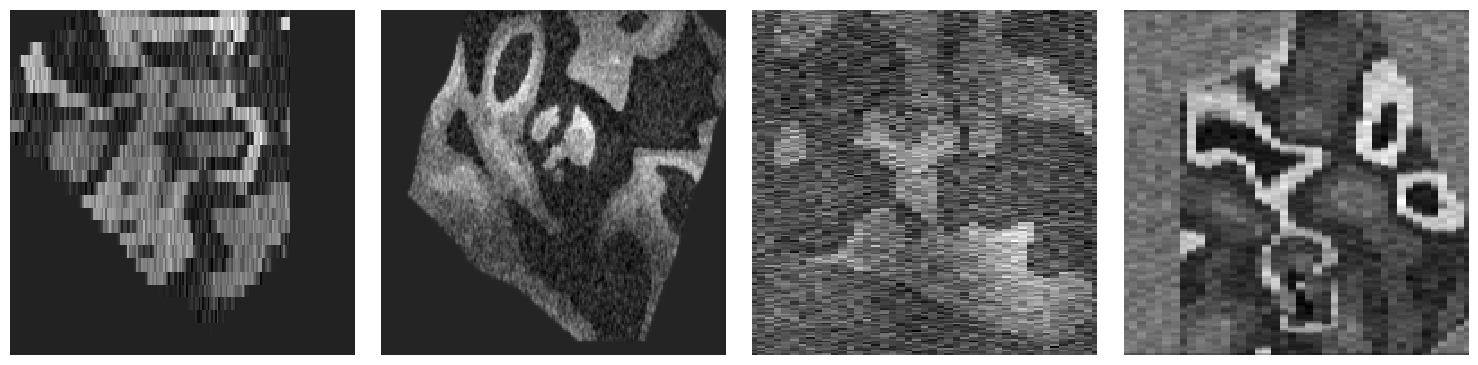

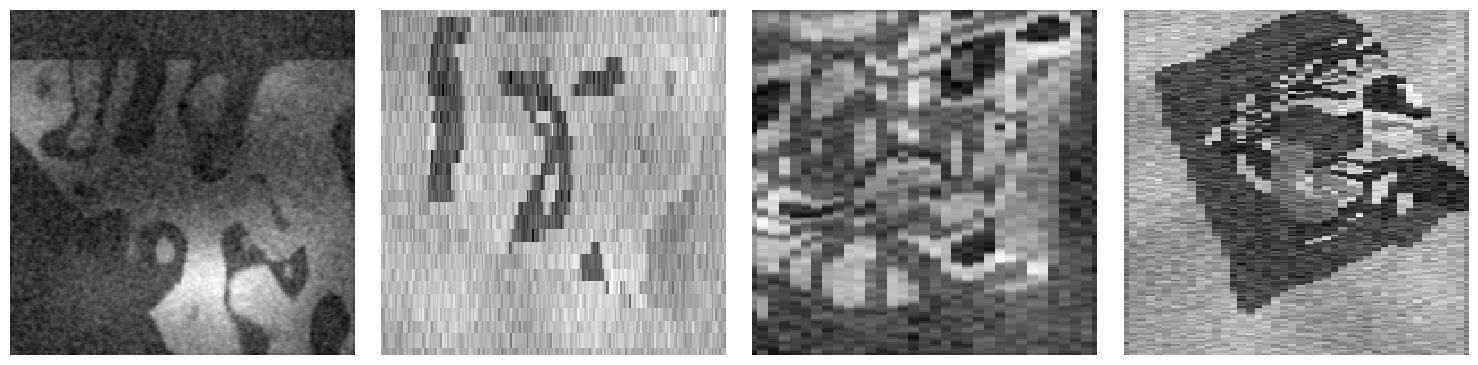

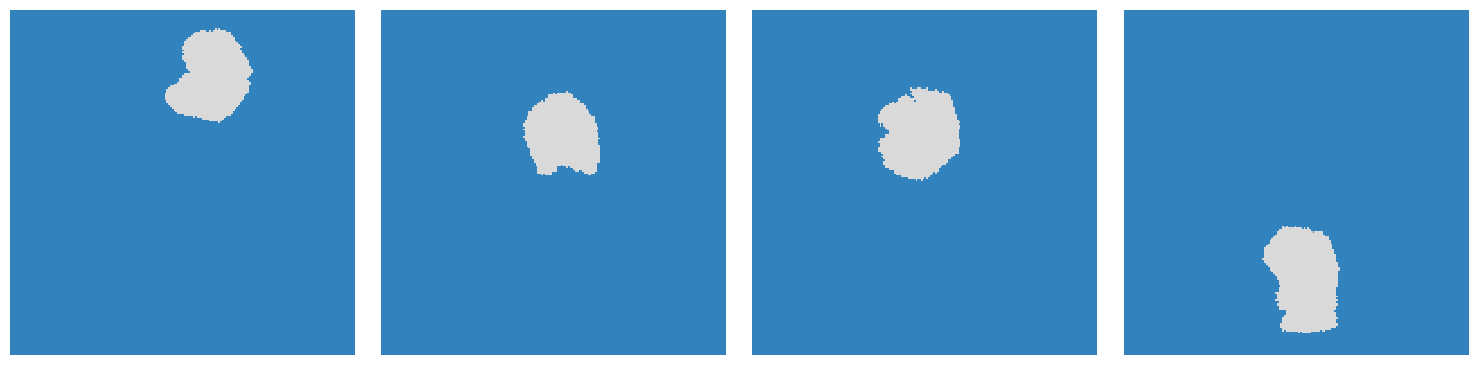

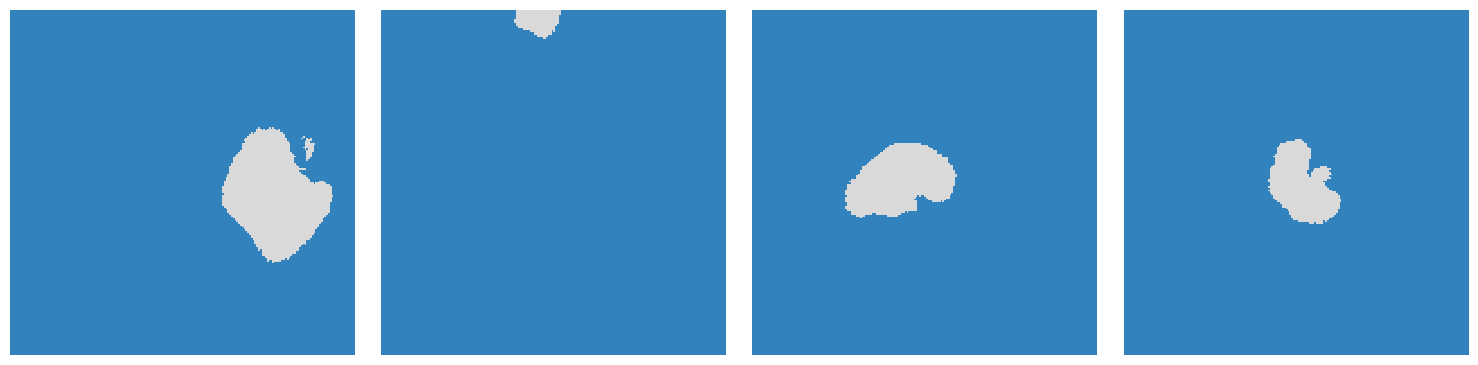

(<Figure size 1500x375 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

In [7]:
# print(output_brain.shape)
images = []
one_hots = []
slices_at_com = []
images_at_com = []

for i in range(num_gen):
    im, oh = zip(*[model3.predict(output_labels[i], verbose=0) for _ in range(1)])
    a = np.squeeze(np.argmax(oh[0],axis=-1),axis=(0))
    com = np.round(center_of_mass(a * ((a >= 1) & (a <= 1)))).astype(int)   
    b = np.squeeze(im[0],axis=(0,-1))
    images_at_com.append(b[:,: ,com[2]])

    nib.save(nib.Nifti1Image(np.squeeze(im[0], axis=(0, -1)), np.eye(4)), f"samples/feta_shapes_{i}.nii.gz")
    nib.save(nib.Nifti1Image(np.argmax(oh[0],axis=-1).squeeze(axis=0).astype(np.int32), np.eye(4)), f"samples/feta_mask_shapes{i}.nii.gz")
    # nib.save(nib.Nifti1Image(np.argmax(oh[0],axis=-1).squeeze(axis=0).astype(np.int32), np.eye(4)), f"samples/feta_resized_shapes{i}.nii.gz")
    # ne.plot.volume3D(im[0])
    # ne.plot.volume3D(np.argmax(oh[0],axis=-1))
    # ne.plot.volume3D(np.argmax(oh[0],axis=-1))
    # # print(a.shape)
    # com = np.round(center_of_mass(a * ((a >= 1) & (a <= 7)))).astype(int)    
    slice_at_com = a[:, :, com[2]]
    slices_at_com.append(slice_at_com)
    # print(np.unique(slice_at_com))



ne.plot.slices(images_at_com[0:4])#, cmaps=['tab20c'])
ne.plot.slices(images_at_com[5:9])#, cmaps=['tab20c'])
# ne.plot.slices(images_at_com[10:14])#, cmaps=['tab20c'])
# ne.plot.slices(images_at_com[15:18])

ne.plot.slices(slices_at_com[0:4], cmaps=['tab20c'])
ne.plot.slices(slices_at_com[5:9], cmaps=['tab20c'])
# ne.plot.slices(slices_at_com[10:14], cmaps=['tab20c'])
# ne.plot.slices(slices_at_com[15:18], cmaps=['tab20c'])
    # ne.plot(a[com],cmaps=['tab20c'])

In [144]:
# np.argmax(oh[0],axis=-1).squeeze(axis=0).astype(np.int32).shape
print(max(labels))

7


In [16]:
oh[0].shape

(1, 256, 256, 256, 17)

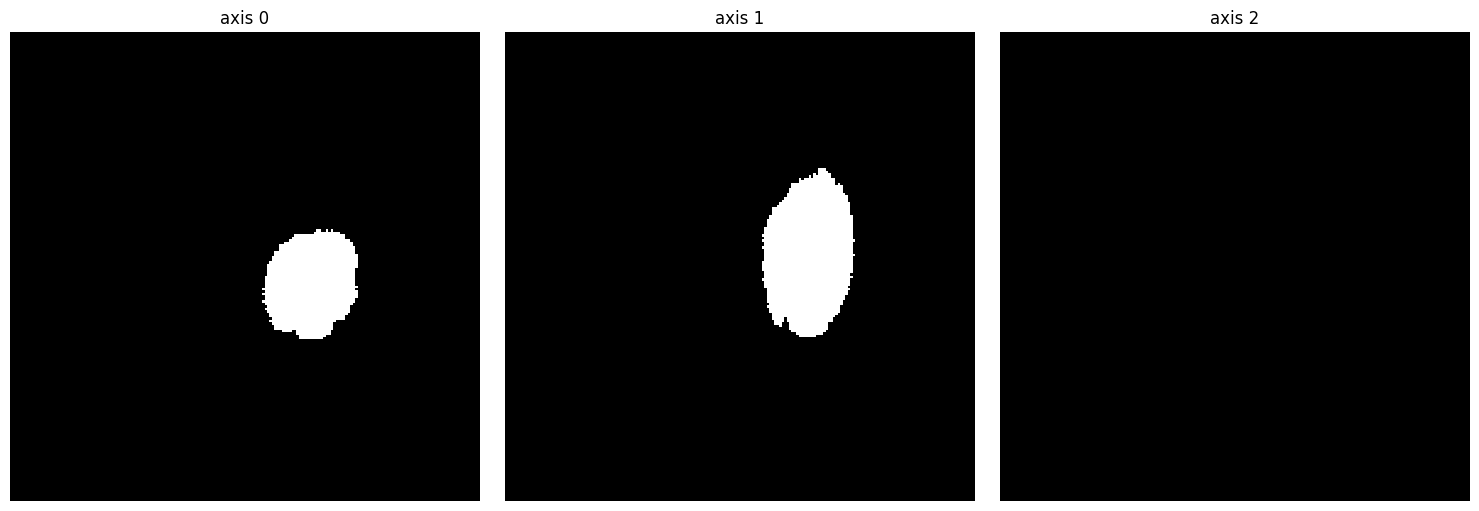

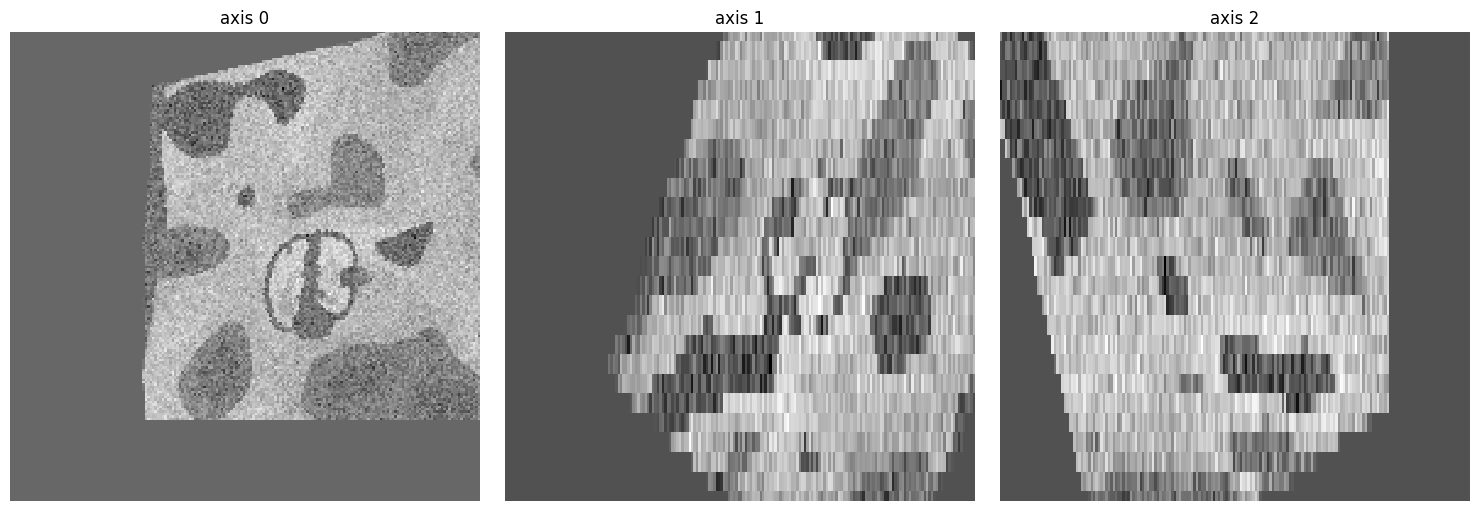

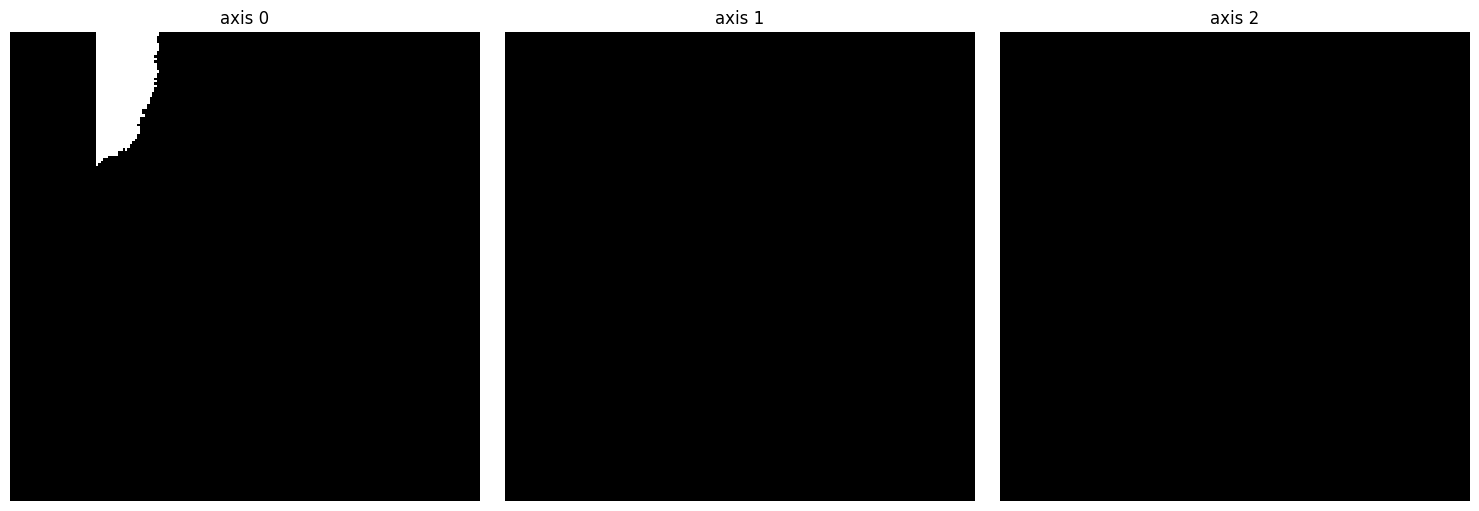

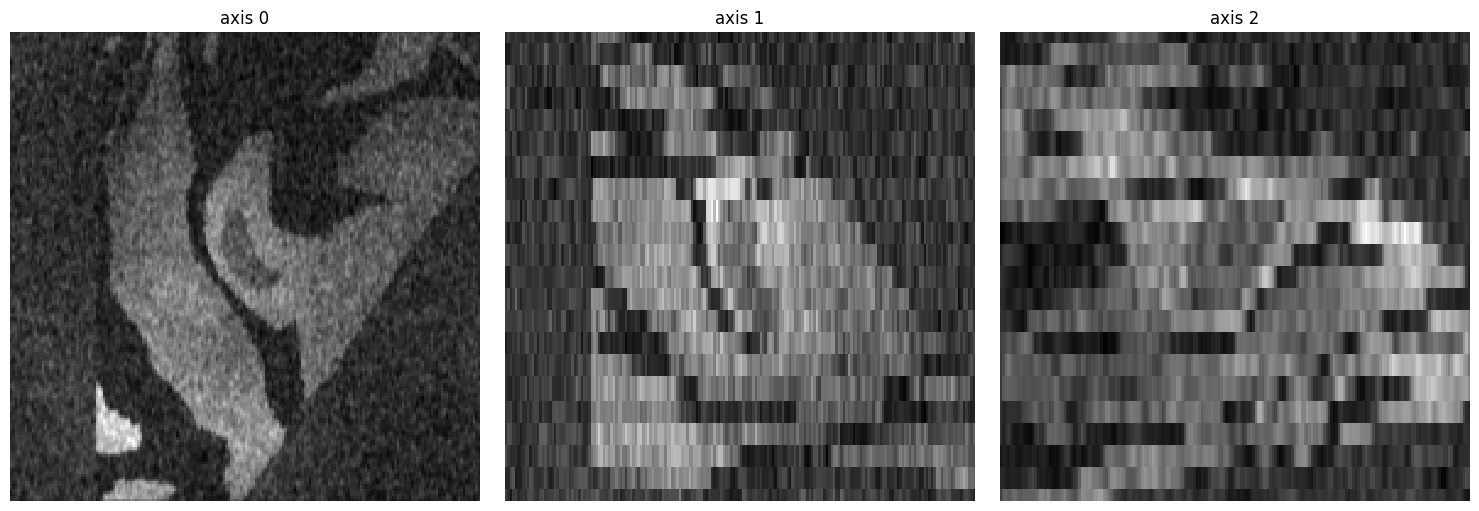

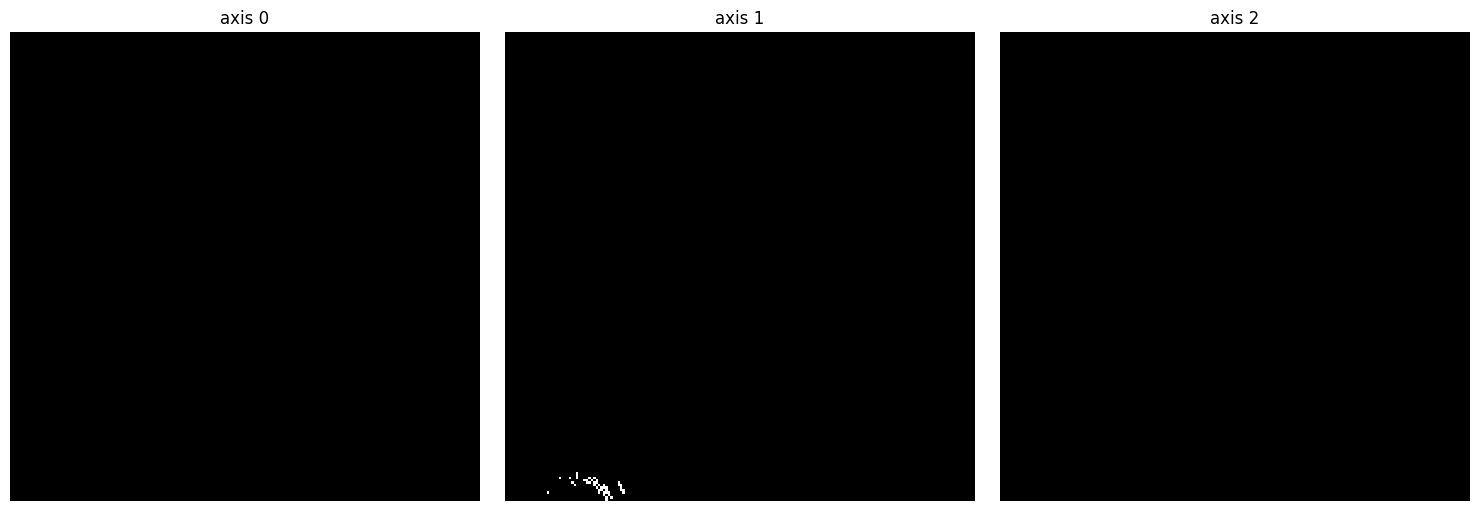

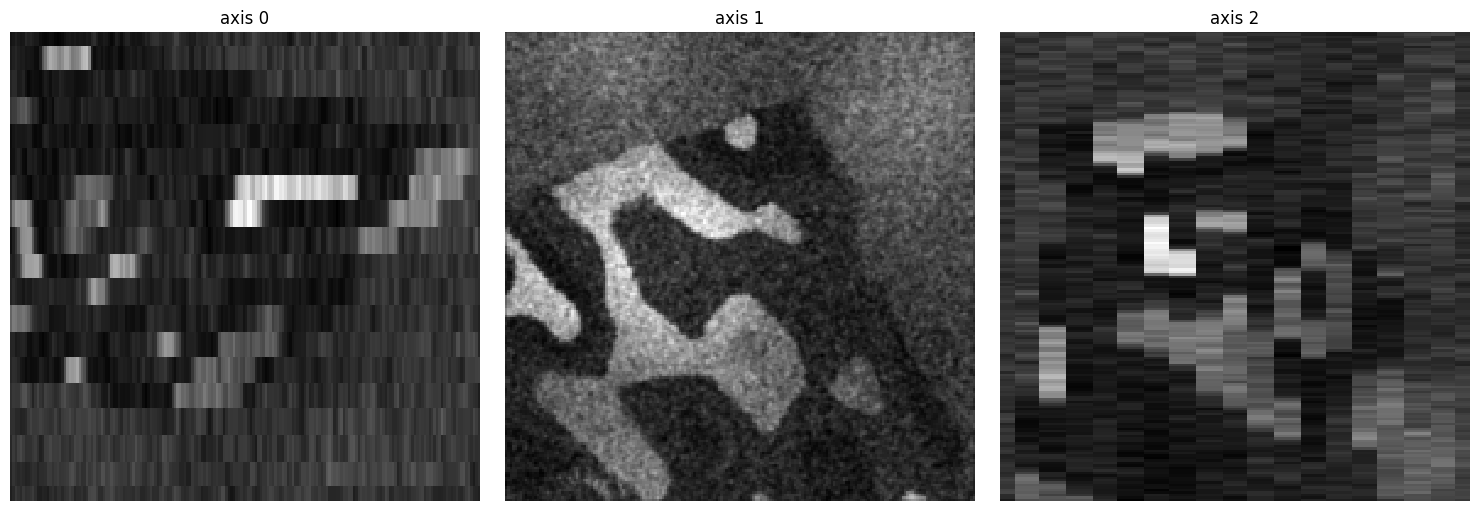

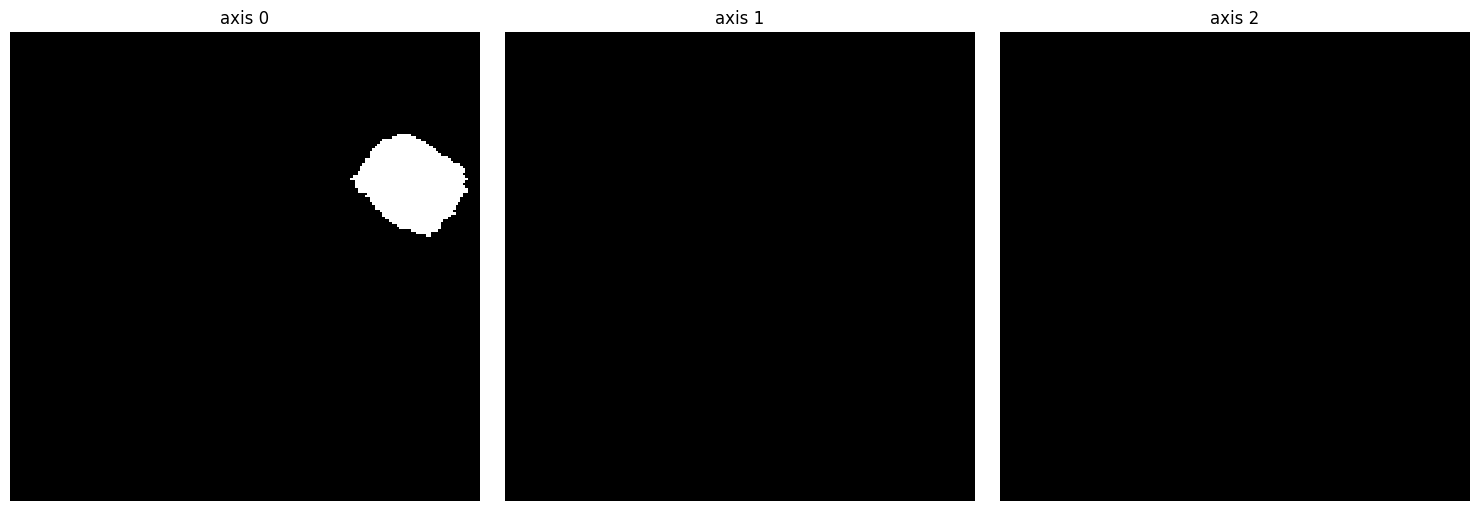

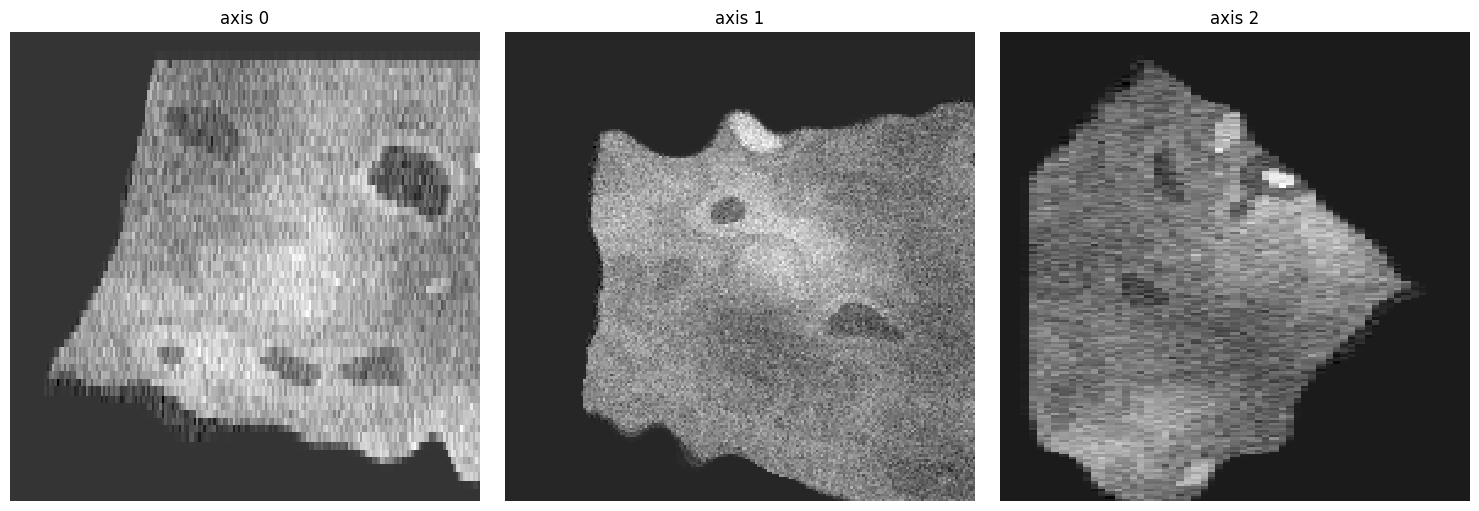

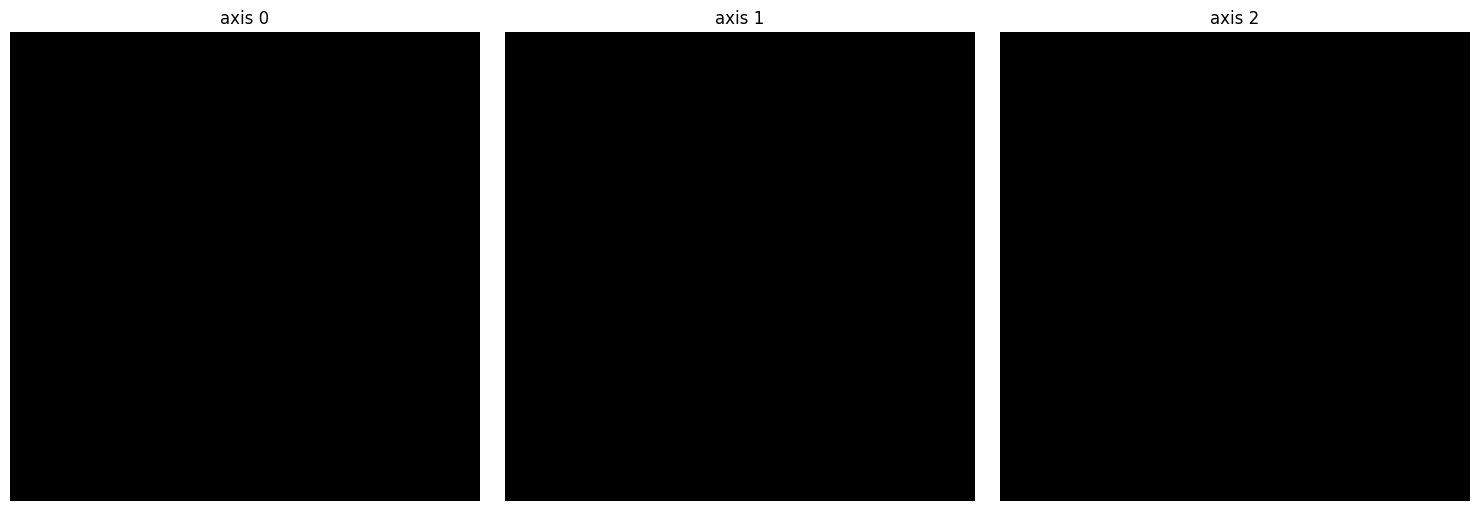

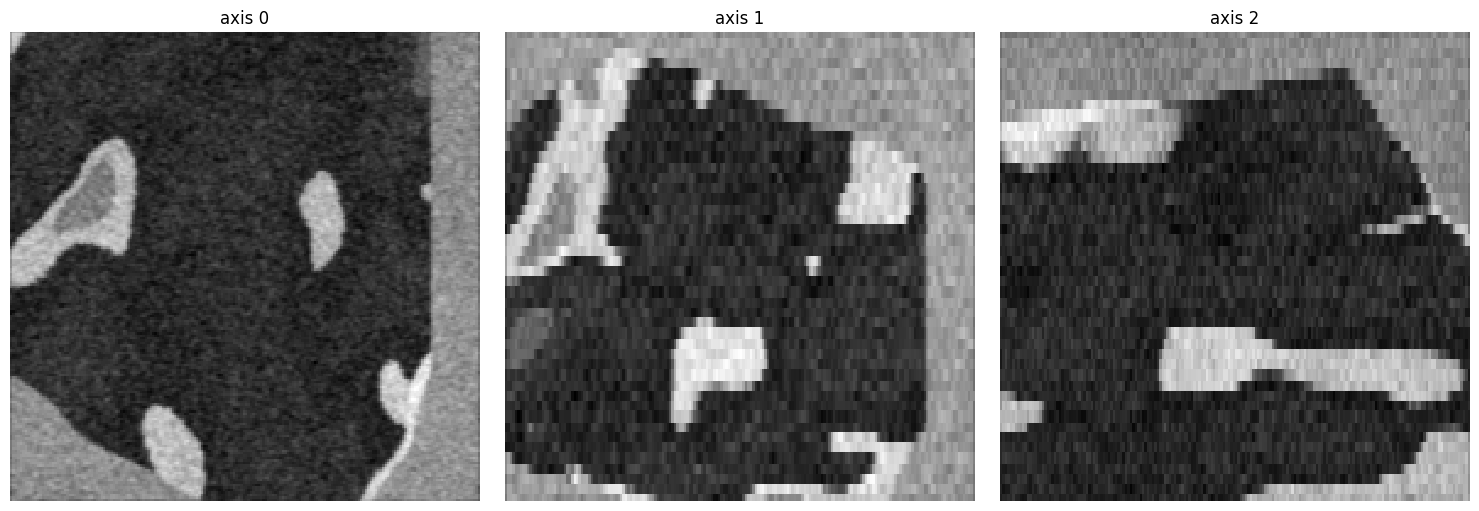

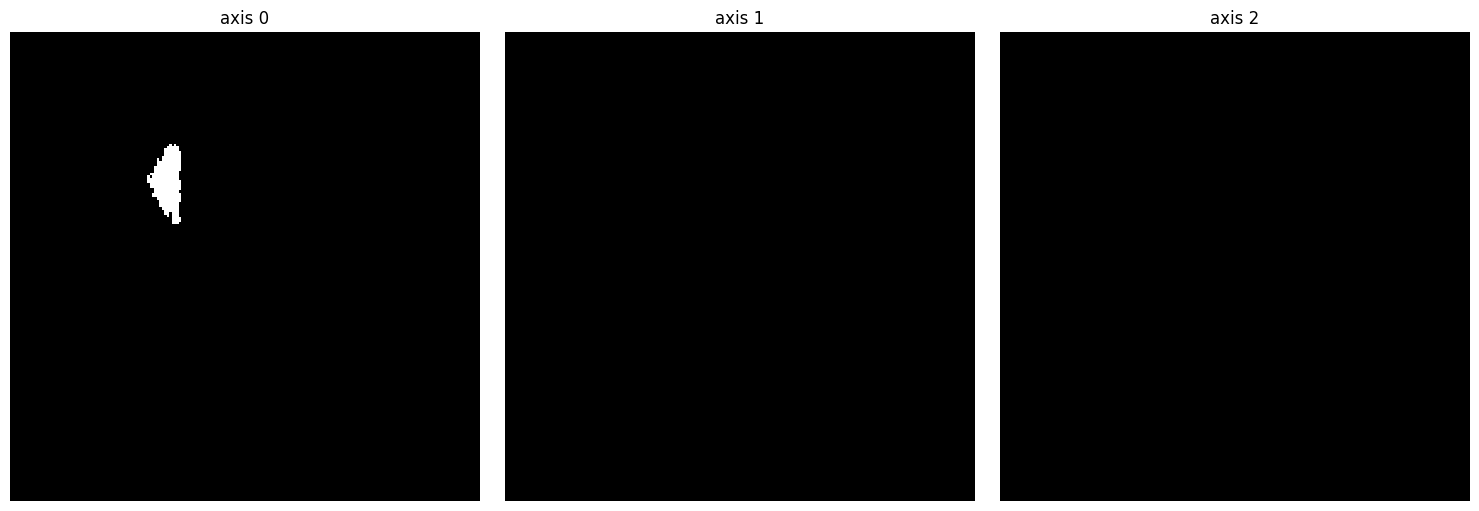

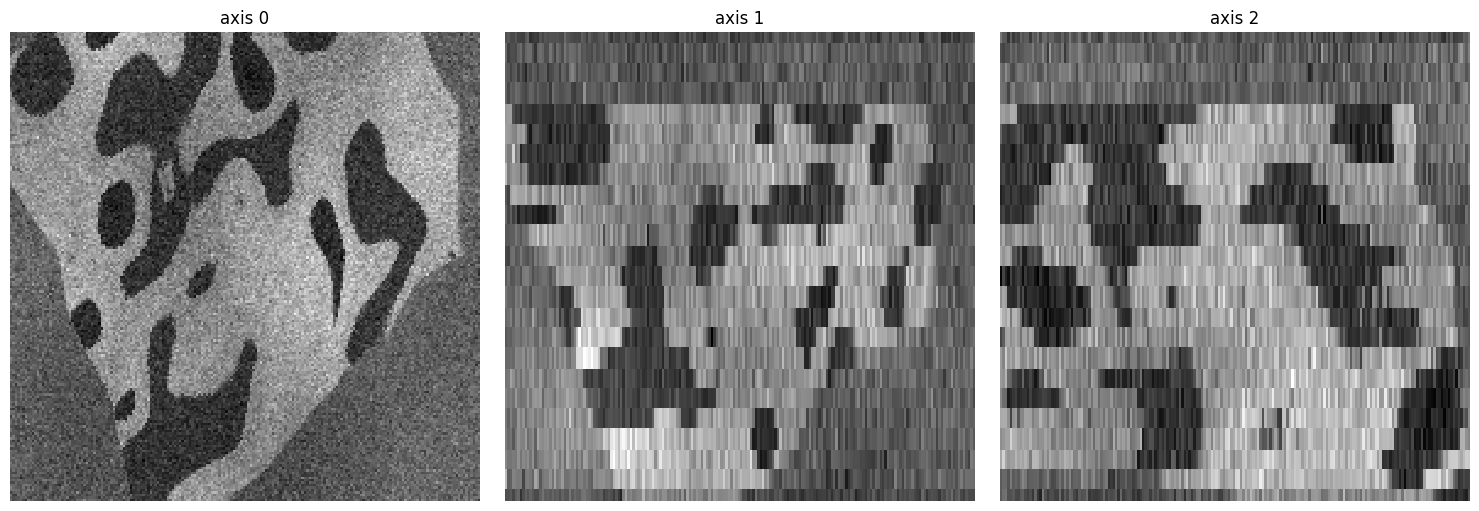

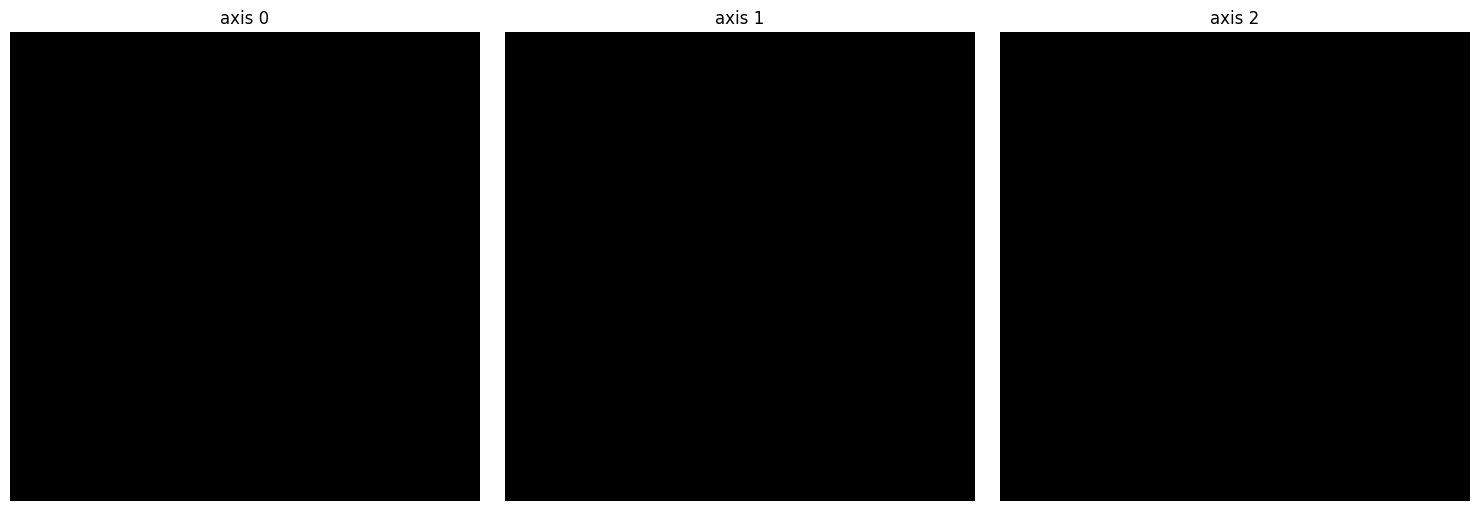

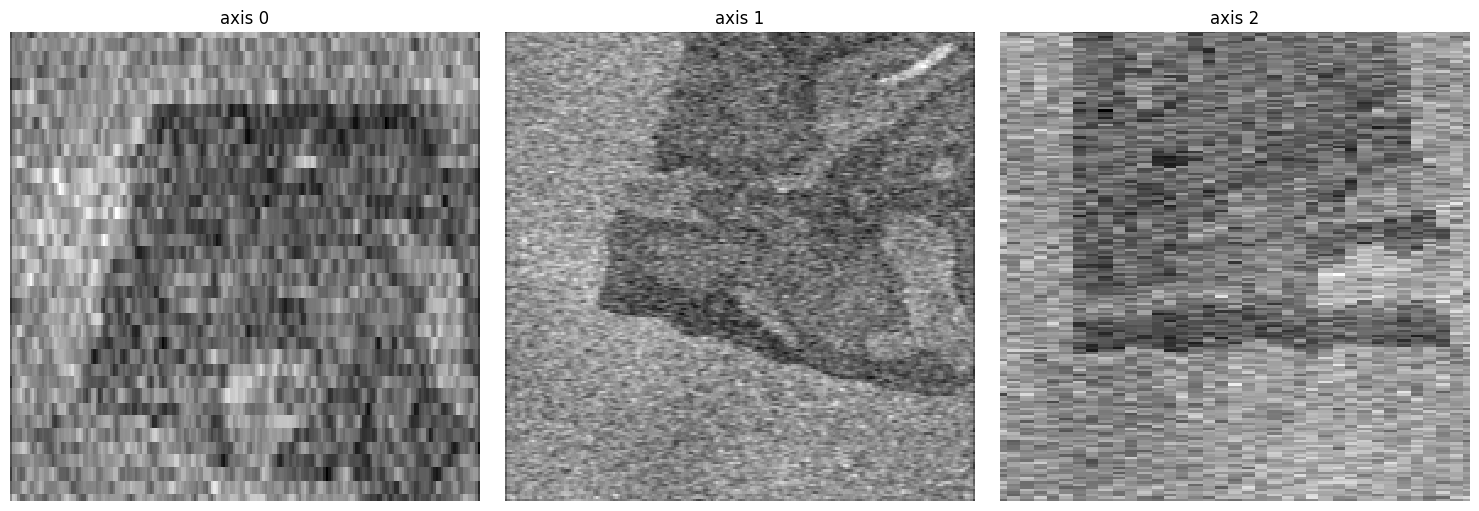

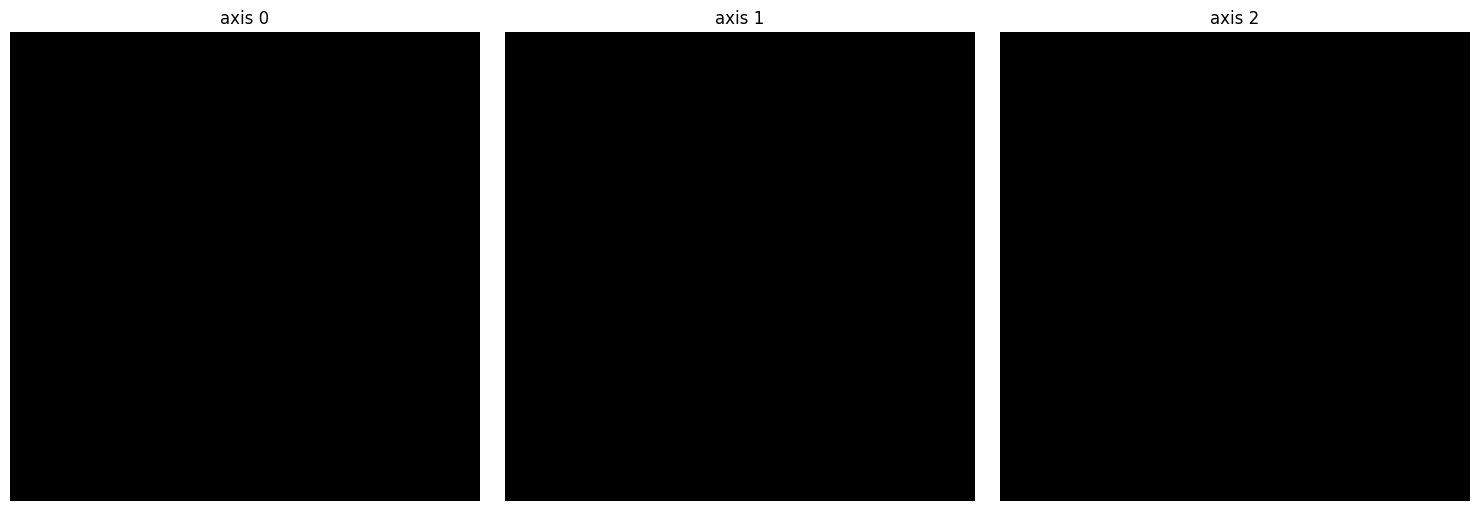

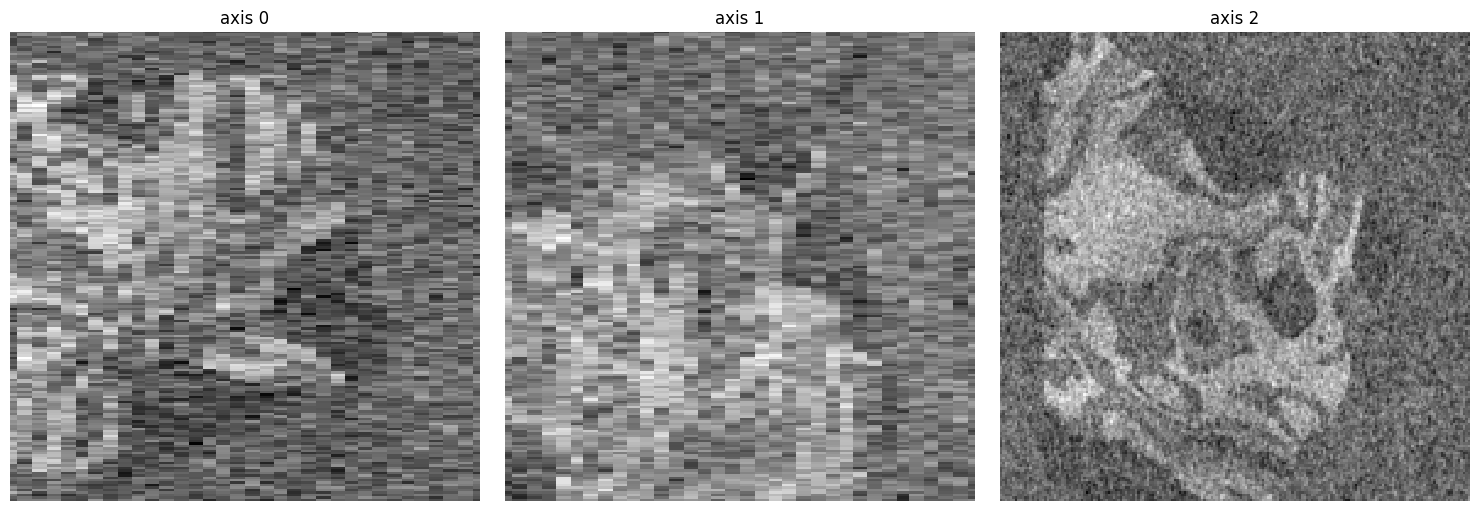

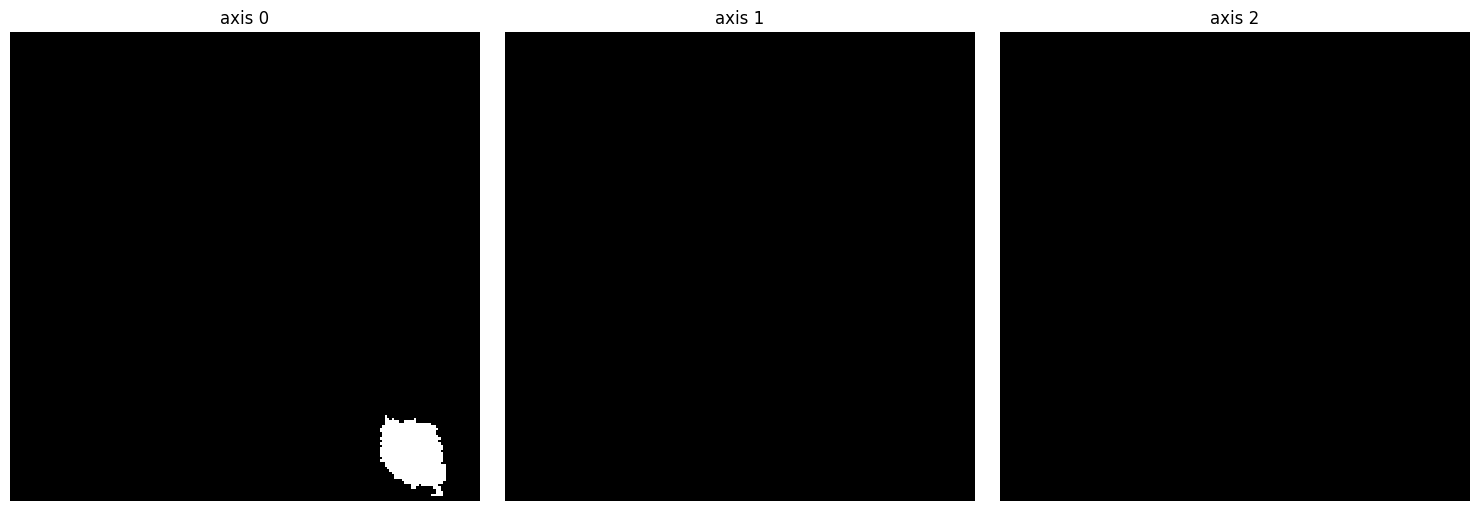

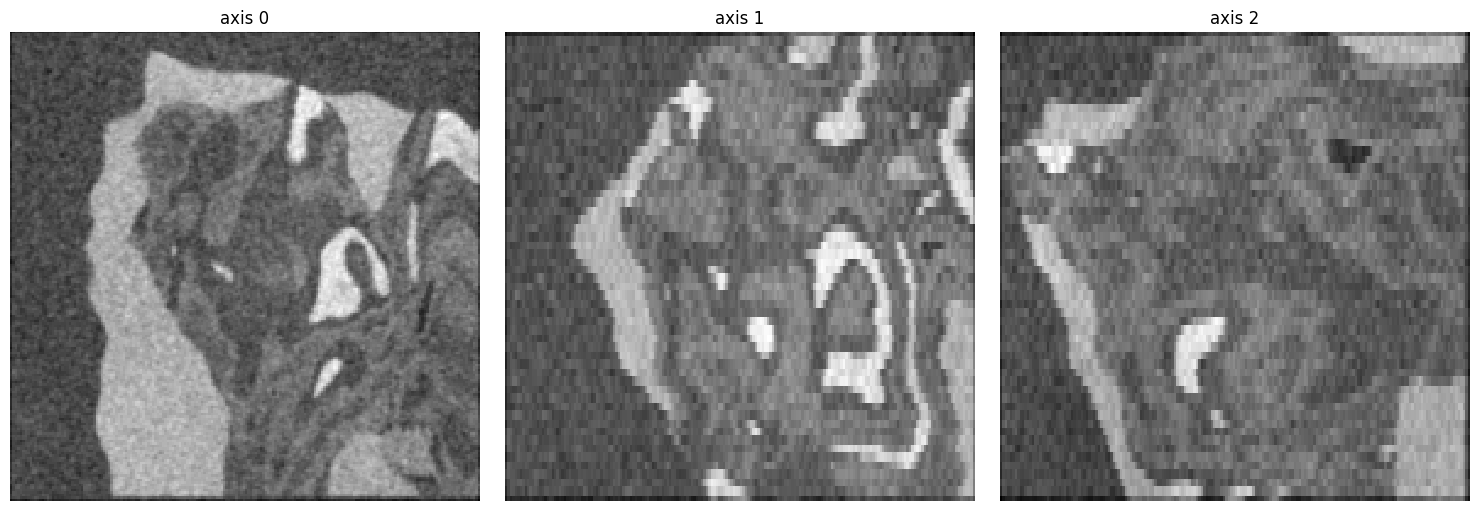

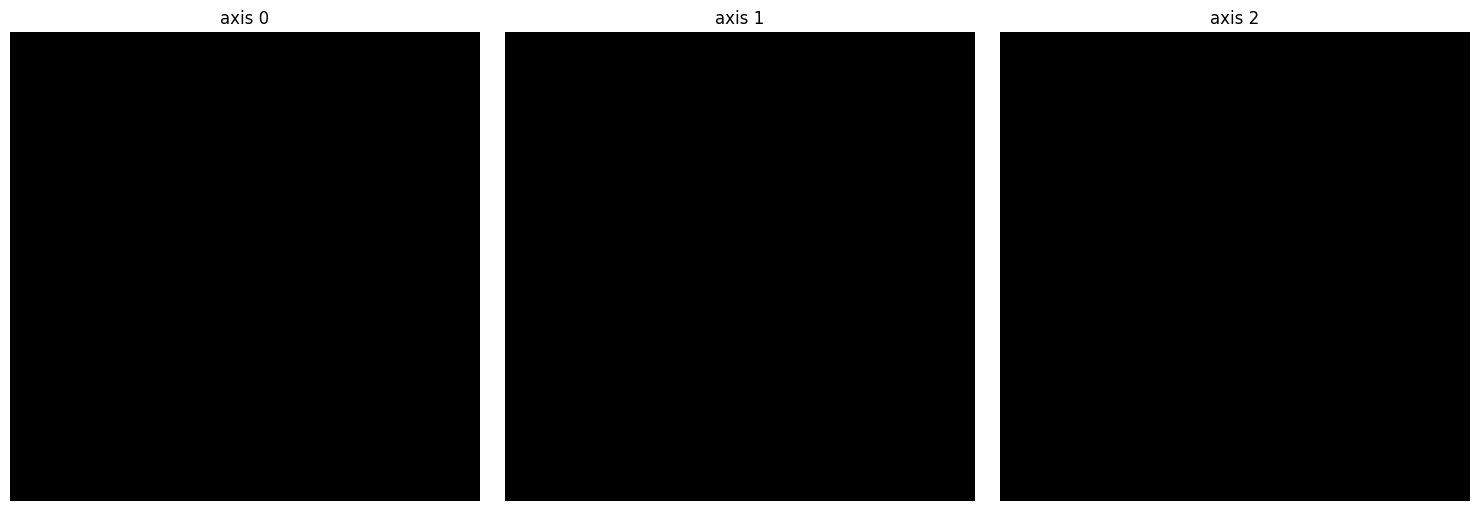

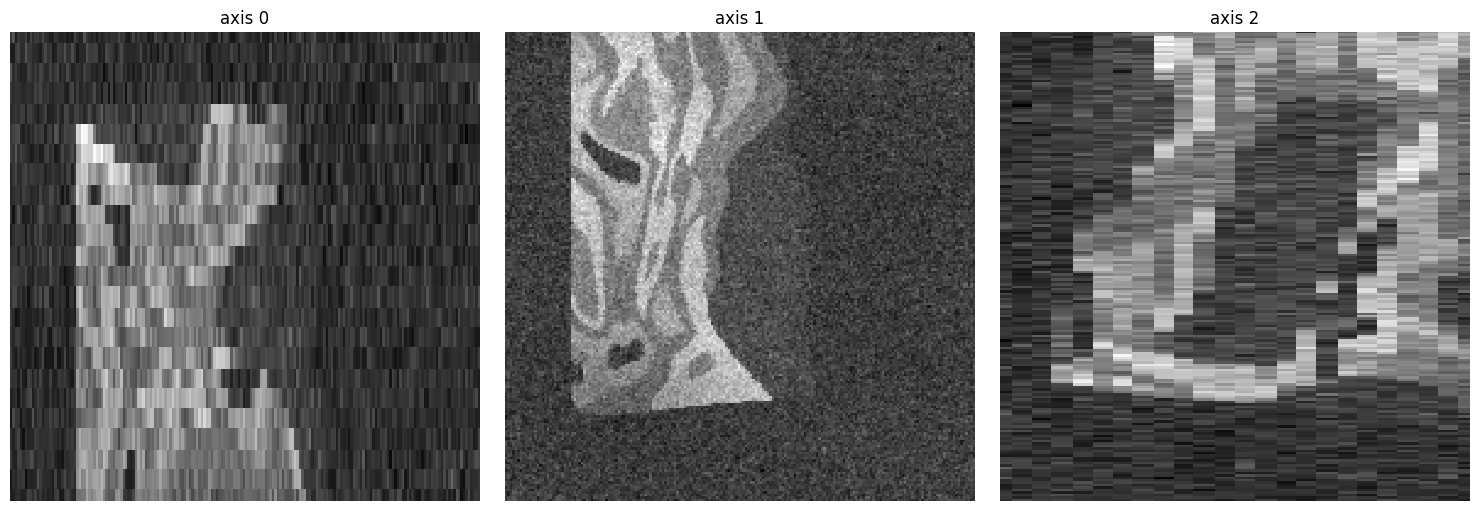

In [8]:
images = []
one_hots = []
for i in range(num_gen):
    im, oh = zip(*[model3.predict(output_labels[i], verbose=0) for _ in range(1)])
    nib.save(nib.Nifti1Image(np.squeeze(im[0], axis=(0, -1)), np.eye(4)), f"samples/feta_shapes_{i}.nii.gz")
    nib.save(nib.Nifti1Image(np.argmax(oh[0],axis=-1).squeeze(axis=0).astype(np.int32), np.eye(4)), f"samples/feta_mask_shapes{i}.nii.gz")
    ne.plot.volume3D(np.argmax(oh[0],axis=-1))
    # ne.plot.volume3D(np.argmax(oh[0],axis=-1))
    ne.plot.volume3D(im)

In [7]:
output_label.shape

(1, 256, 256, 256, 1)